# Link Unet Membrane
https://www.kaggle.com/datasets/tasmiarahmanaanika/unet-lung-mask

In [81]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow as tf

from glob import glob
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

# Load Dataset Training dan Valid

In [82]:
# Function to replace NaN values with 0
def replace_nan_with_zero(df, columns=None, inplace=True):
    if columns is None:
        if inplace:
            df.fillna(0, inplace=True)
            return None
        else:
            return df.fillna(0)
    else:
        # limit replacement only to the specified columns
        if inplace:
            df[columns] = df[columns].fillna(0)
            return None
        else:
            new_df = df.copy()
            new_df[columns] = new_df[columns].fillna(0)
            return new_df

In [83]:
# Number of rows to sample
n_rows = 10000

# Read and sample randomly
train_df = pd.read_csv("train.csv")
train_df.drop(columns=['_id'], inplace=True, errors='ignore')
train_df = train_df.sample(n=n_rows, random_state=42) 
train_df = train_df.reset_index(drop=True) 
train_df.head()

Path     Sex  Age  \
0  D:/Downloads/train/patient00082/study1/view1_f...    Male   18   
1  D:/Downloads/train/patient35759/study9/view1_f...    Male   90   
2  D:/Downloads/train/patient04789/study1/view2_l...    Male   39   
3  D:/Downloads/train/patient38491/study5/view1_f...    Male   60   
4  D:/Downloads/train/patient06537/study3/view1_f...  Female   66   

  Frontal_Lateral AP_PA  No_Finding  Enlarged_Cardiomediastinum  Cardiomegaly  \
0         Frontal    PA           1                           0             0   
1         Frontal    AP           0                           0             1   
2         Lateral     0           0                           0             0   
3         Frontal    AP           0                           0             0   
4         Frontal    AP           0                           0             0   

   Lung_Opacity  Lung_Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0             0            0      0              0          0            0   
1             0            0      1              0          0            1   
2             0            1      0              0          0            0   
3             0            0      1              0          0            0   
4             1            0      0              0          0            1   

   Pneumothorax  Pleural_Effusion  Pleural_Other  Fracture  Support_Devices  
0             0                 0              0         0                0  
1             0                 0              0         0                1  
2             0                 1              0         0                0  
3             0                 0              0         0                1  
4             0                 0              0         0                0

In [84]:
# Function to prepare dataset based on labeling policy 
def prepare_dataset(dataframe, policy, class_names):
    df = dataframe.sample(frac=1.0, random_state=1)
    x_path = df["Path"].to_numpy()
    
    y_df = df[class_names]
    
    class_ones = ['Atelectasis', 'Cardiomegaly'] 
    y = np.empty(y_df.shape, dtype=int)
    
    for i, (_, row) in enumerate(y_df.iterrows()):
        labels = []
        for cls in class_names:
            curr_val = row[cls]
            feat_val = 0

            if curr_val is not None:
                try:
                    curr_val = float(curr_val)
                except:
                    curr_val = 0

                if curr_val == 1:
                    feat_val = 1
                elif curr_val == -1:
                    if policy == "ones":
                        feat_val = 1
                    elif policy == "zeroes":
                        feat_val = 0
                    elif policy == "mixed":
                        feat_val = 1 if cls in class_ones else 0
                else:
                    feat_val = 0
            labels.append(feat_val)
        y[i] = labels
    
    return x_path, y


In [85]:
# Classes used based on CheXpert paper
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural_Effusion']
policy = ['ones','zeroes','mixed']
x_path,labels = prepare_dataset(train_df,policy[-1],class_names)

In [86]:
print(x_path)

['D:/Downloads/train/patient14339/study4/view1_frontal.jpg'
 'D:/Downloads/train/patient33200/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient13227/study13/view1_frontal.jpg' ...
 'D:/Downloads/train/patient48113/study1/view1_frontal.jpg'
 'D:/Downloads/train/patient02044/study2/view1_frontal.jpg'
 'D:/Downloads/train/patient35025/study9/view1_frontal.jpg']


In [87]:
# Get data
train_df = pd.DataFrame({'path':x_path})
df2 = pd.DataFrame(labels,columns=class_names)
train_df[list(df2.columns)]=df2 

In [88]:
train_df

path  Atelectasis  \
0     D:/Downloads/train/patient14339/study4/view1_f...            0   
1     D:/Downloads/train/patient33200/study1/view1_f...            0   
2     D:/Downloads/train/patient13227/study13/view1_...            0   
3     D:/Downloads/train/patient37912/study12/view1_...            0   
4     D:/Downloads/train/patient32046/study3/view1_f...            1   
...                                                 ...          ...   
9995  D:/Downloads/train/patient00674/study2/view1_f...            1   
9996  D:/Downloads/train/patient41032/study2/view1_f...            0   
9997  D:/Downloads/train/patient48113/study1/view1_f...            0   
9998  D:/Downloads/train/patient02044/study2/view1_f...            0   
9999  D:/Downloads/train/patient35025/study9/view1_f...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                0              0      0                 1  
2                0              0      0                 0  
3                0              0      1                 0  
4                0              0      0                 1  
...            ...            ...    ...               ...  
9995             0              0      1                 1  
9996             1              0      0                 0  
9997             0              0      0                 0  
9998             1              0      1                 1  
9999             0              0      0                 1  

[10000 rows x 6 columns]

Clean Labels Summary:
Pleural_Effusion    3830
Atelectasis         3019
Edema               2308
Cardiomegaly        1546
Consolidation        628
dtype: int64


(<Axes: xlabel='None', ylabel='0'>,
 ([0, 1, 2, 3, 4],
  [Text(0, 0, 'Pleural_Effusion'),
   Text(1, 0, 'Atelectasis'),
   Text(2, 0, 'Edema'),
   Text(3, 0, 'Cardiomegaly'),
   Text(4, 0, 'Consolidation')]))

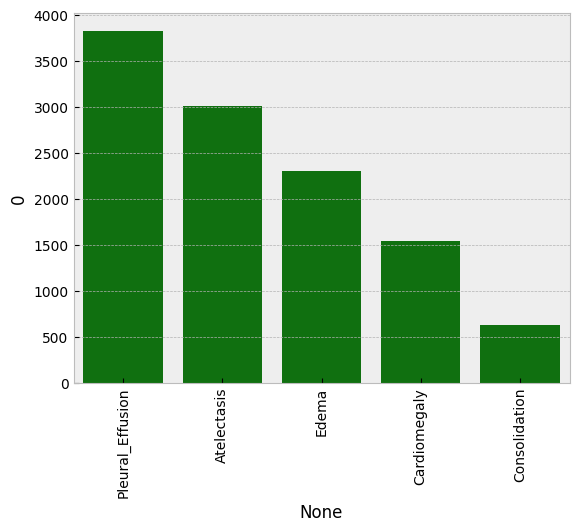

In [89]:
print("Clean Labels Summary:")
clean_labels = train_df[class_names].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [90]:
# get valid dataset
valid_df = pd.read_csv("valid.csv")
valid_df.drop(columns=['_id'], inplace=True, errors='ignore')
# Replace any NaNs with 0 
replace_nan_with_zero(valid_df)
valid_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral     0         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

In [91]:
my_glob_valid = [x.replace('\\', '/') for x in glob('D:/Downloads/valid/patient*/study*/*.jpg')]
print('Number of Observations: ', len(my_glob_valid)) 

Number of Observations:  234


In [92]:
images_directory_valid = "D:/Downloads/valid"

full_img_paths = {}

# Full image mapping (source images)
for x in my_glob_valid:
    rel_path = os.path.relpath(x, images_directory_valid)
    key = 'CheXpert-v1.0-small/valid/' + rel_path.replace('\\', '/')
    full_img_paths[key] = x.replace('\\', '/')
    
# Map the correct paths to the dataframe
valid_df['Path'] = valid_df['Path'].map(full_img_paths.get)
valid_df.columns = valid_df.columns.str.replace(' ', '_')

In [93]:
valid_x_path,valid_labels = prepare_dataset(valid_df,policy[-1],class_names)

In [94]:
valid_df = pd.DataFrame({'path':valid_x_path})
df2 = pd.DataFrame(labels,columns=class_names)
valid_df[list(df2.columns)]=df2 
valid_df

path  Atelectasis  \
0    D:/Downloads/valid/patient64706/study1/view1_f...            0   
1    D:/Downloads/valid/patient64592/study1/view1_f...            0   
2    D:/Downloads/valid/patient64740/study1/view1_f...            0   
3    D:/Downloads/valid/patient64570/study1/view1_f...            0   
4    D:/Downloads/valid/patient64647/study1/view1_f...            1   
..                                                 ...          ...   
229  D:/Downloads/valid/patient64710/study1/view1_f...            0   
230  D:/Downloads/valid/patient64646/study1/view1_f...            1   
231  D:/Downloads/valid/patient64594/study1/view2_l...            1   
232  D:/Downloads/valid/patient64649/study1/view1_f...            1   
233  D:/Downloads/valid/patient64568/study1/view1_f...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [95]:
my_glob_train = train_df['path'].tolist()
print('Number of Observations: ', len(my_glob_train)) 

Number of Observations:  10000


In [96]:
print(my_glob_train)

['D:/Downloads/train/patient14339/study4/view1_frontal.jpg', 'D:/Downloads/train/patient33200/study1/view1_frontal.jpg', 'D:/Downloads/train/patient13227/study13/view1_frontal.jpg', 'D:/Downloads/train/patient37912/study12/view1_frontal.jpg', 'D:/Downloads/train/patient32046/study3/view1_frontal.jpg', 'D:/Downloads/train/patient32680/study3/view1_frontal.jpg', 'D:/Downloads/train/patient58692/study1/view1_frontal.jpg', 'D:/Downloads/train/patient23729/study5/view1_frontal.jpg', 'D:/Downloads/train/patient33805/study1/view2_lateral.jpg', 'D:/Downloads/train/patient03763/study21/view1_frontal.jpg', 'D:/Downloads/train/patient01494/study2/view1_frontal.jpg', 'D:/Downloads/train/patient25069/study5/view1_frontal.jpg', 'D:/Downloads/train/patient40497/study4/view2_lateral.jpg', 'D:/Downloads/train/patient33155/study4/view1_frontal.jpg', 'D:/Downloads/train/patient29597/study1/view2_lateral.jpg', 'D:/Downloads/train/patient13660/study1/view1_frontal.jpg', 'D:/Downloads/train/patient22306/stu

# Resize Gambar

In [97]:
import cv2
import numpy as np

# function to resize input image with padding
def resize_with_padding(img, target_size=224, pad_color=0):
    h, w = img.shape[:2]

    # Scale with ratio maintained
    if h > w:
        new_h = target_size
        new_w = int(w * (target_size / h))
    else:
        new_w = target_size
        new_h = int(h * (target_size / w))

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Calculate padding
    pad_vert = target_size - new_h
    pad_horz = target_size - new_w

    top = pad_vert // 2
    bottom = pad_vert - top
    left = pad_horz // 2
    right = pad_horz - left

    # Add padding
    padded = cv2.copyMakeBorder(
        resized,
        top, bottom, left, right,
        cv2.BORDER_CONSTANT,
        value=pad_color,
    )

    return padded


In [98]:
def get_all_images(root_dir):
    exts = [".png", ".jpg", ".jpeg", ".bmp"]
    collected = []

    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if any(f.lower().endswith(e) for e in exts):
                collected.append(os.path.join(root, f))

    return collected

Pengaturan Direktori dan Resize Gambar

In [99]:
import cv2
from tqdm import tqdm

# resized directory 
resized_valid = "D:/Downloads/valid_resized"
resized_train = "D:/Downloads/train_resized"

TARGET_SIZE = 256
PAD_COLOR = 0 

In [100]:
def resize_images(my_glob, resized_output_dir):
    processed = 0
    failed = 0
    
    os.makedirs(resized_output_dir, exist_ok=True)
    
    glob = []
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(resized_output_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions:
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} resized images.")
        return glob
    else:
        print("No resized images found.")

        for img_path in tqdm(my_glob, desc="Resizing images"):
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            if img is None:
                print(f"Failed to read image: {img_path}")
                failed += 1
                continue

            resized_img = resize_with_padding(img, target_size=TARGET_SIZE, pad_color=PAD_COLOR)

            # Build relative path from the glob path
            parts = img_path.replace("\\", "/").split("/")
            rel = "/".join(parts[3:])  # keep everything after the top-level folder

            out_path = os.path.join(resized_output_dir, rel)
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            if resized_img.dtype != np.uint8:
                max_val = resized_img.max() or 1.0
                if max_val <= 1.0:
                    save_img = (resized_img * 255).astype(np.uint8)
                else:
                    save_img = resized_img.astype(np.uint8)
            else:
                save_img = resized_img

            success = cv2.imwrite(out_path, save_img)
            if not success:
                print(f"Failed to save: {out_path}")
                failed += 1
                continue
            
            processed += 1
            glob.append(out_path)
            
        print(f"Done. Processed: {processed}, Failed: {failed}")    
        return glob


In [101]:
glob_valid_resize = resize_images(my_glob_valid, resized_valid)

Found 234 resized images.


In [102]:
glob_train_resize = resize_images(my_glob_train, resized_train)

Found 10000 resized images.


In [103]:
print(glob_valid_resize)

['D:/Downloads/valid_resized\\patient64541\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64542\\study1\\view2_lateral.jpg', 'D:/Downloads/valid_resized\\patient64543\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64544\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64545\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64546\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view2_frontal.jpg', 'D:/Downloads/valid_resized\\patient64547\\study1\\view3_lateral.jpg', 'D:/Downloads/valid_resized\\patient64548\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64549\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64550\\study1\\view1_frontal.jpg', 'D:/Downloads/valid_resized\\patient64551\\study1\\view1_frontal.jpg', 'D:/D

In [104]:
print(glob_train_resize)

['D:/Downloads/train_resized\\patient00006\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00012\\study3\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00023\\study6\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00039\\study7\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00042\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00059\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00066\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00067\\study3\\view2_lateral.jpg', 'D:/Downloads/train_resized\\patient00069\\study17\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study27\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00069\\study43\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00081\\study1\\view2_frontal.jpg', 'D:/Downloads/train_resized\\patient00082\\study1\\view1_frontal.jpg', 'D:/Downloads/train_resized\\patient00084\\study2\\view1_frontal.jpg', 'D

In [105]:
def replace_path(dataframe, glob):
    mapping = {}
    for path, new_path in zip(dataframe['path'], glob):
        mapping[path.replace("\\", "/")] = new_path.replace("\\", "/")
        
    dataframe['path'] = dataframe['path'].map(mapping.get)
    return dataframe

In [106]:
valid_df = replace_path(valid_df, glob_valid_resize)
valid_df

path  Atelectasis  \
0    D:/Downloads/valid_resized/patient64541/study1...            0   
1    D:/Downloads/valid_resized/patient64542/study1...            0   
2    D:/Downloads/valid_resized/patient64542/study1...            0   
3    D:/Downloads/valid_resized/patient64543/study1...            0   
4    D:/Downloads/valid_resized/patient64544/study1...            1   
..                                                 ...          ...   
229  D:/Downloads/valid_resized/patient64736/study1...            0   
230  D:/Downloads/valid_resized/patient64737/study1...            1   
231  D:/Downloads/valid_resized/patient64738/study1...            1   
232  D:/Downloads/valid_resized/patient64739/study1...            1   
233  D:/Downloads/valid_resized/patient64740/study1...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [107]:
train_df = replace_path(train_df, glob_train_resize)
train_df

path  Atelectasis  \
0     D:/Downloads/train_resized/patient00006/study1...            0   
1     D:/Downloads/train_resized/patient00012/study3...            0   
2     D:/Downloads/train_resized/patient00023/study6...            0   
3     D:/Downloads/train_resized/patient00039/study7...            0   
4     D:/Downloads/train_resized/patient00042/study1...            1   
...                                                 ...          ...   
9995  D:/Downloads/train_resized/patient64491/study2...            1   
9996  D:/Downloads/train_resized/patient64498/study1...            0   
9997  D:/Downloads/train_resized/patient64501/study1...            0   
9998  D:/Downloads/train_resized/patient64506/study1...            0   
9999  D:/Downloads/train_resized/patient64537/study1...            1   

      Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0                0              0      0                 0  
1                0              0      0                 1  
2                0              0      0                 0  
3                0              0      1                 0  
4                0              0      0                 1  
...            ...            ...    ...               ...  
9995             0              0      1                 1  
9996             1              0      0                 0  
9997             0              0      0                 0  
9998             1              0      1                 1  
9999             0              0      0                 1  

[10000 rows x 6 columns]

# Load Model

In [108]:
from keras.models import load_model

mask_model = load_model("unet_membrane_a6.hdf5")
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
print(mask_model.input_shape)

(None, 256, 256, 1)


In [110]:
mask_output_valid = "D:/Downloads/masks/valid"
mask_output_train = "D:/Downloads/masks/train"

# Membuat Mask untuk Gambar

In [111]:
def preprocess_image(file_path, target_size=(256, 256)):
    img = cv2.imread(file_path)
    if img is None:
        print(f"Error: Unable to read image at {file_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = cv2.equalizeHist(img)   # improve contrast
    img = cv2.GaussianBlur(img, (5,5), 0)  # reduce noise
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)   # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]
    return img

In [112]:
def predict_mask(model, image, verbose=0): 
    pred = model.predict(image, verbose=verbose) * 255
    return pred

In [113]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def predict_mask_image(path_glob, output_directory):
    glob = []
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    valid_extensions = {".jpg", ".jpeg", ".png"}

    for root, dirs, files in os.walk(output_directory):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_mask"):
                glob.append(os.path.join(root, file))
    
    if glob:
        print(f"Found {len(glob)} masks.")
        return glob
    else:
        print("No mask found.")
        for image_path in tqdm(path_glob, desc="Generating masks", unit="img" ):
            test_im = preprocess_image(image_path)
            if test_im is None:
                tqdm.write(f"Failed to preprocess: {image_path}")
                continue

            try:
                mask = predict_mask(mask_model, test_im, verbose=0)
                
                parts = image_path.replace("\\", "/").split("/")
                relative_path = "/".join(parts[3:])  # keep everything after the top-level folder
                mask_path = os.path.join(output_directory, relative_path)
                os.makedirs(os.path.dirname(mask_path), exist_ok=True)
                
                directory, filename = os.path.split(mask_path)
                name, ext = os.path.splitext(filename)
                new_filename = f"{name}_mask{ext}"
                mask_path = os.path.join(directory, new_filename)

                os.makedirs(directory, exist_ok=True)

                mask_to_save = mask[0, :, :, 0]

                se_3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                se_5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
                dst_dilate_inv = cv2.dilate(mask_to_save, se_3, iterations = 1)
                dst_erosi_inv = cv2.erode(dst_dilate_inv, se_3, iterations = 2)
                dst_dilate2_inv = cv2.dilate(dst_erosi_inv, se_5, iterations = 2)
                dst_erosi2_inv = cv2.erode(dst_dilate2_inv, se_5, iterations = 3)
                dst_dilate3_inv = cv2.dilate(dst_erosi2_inv, se_3, iterations = 1)
                mask_to_save = dst_dilate3_inv

                if mask_to_save.dtype != np.uint8:
                    if mask_to_save.max() <= 1.0:
                        mask_to_save = (mask_to_save * 255).astype(np.uint8)
                    else:
                        mask_to_save = mask_to_save.astype(np.uint8)

                if cv2.imwrite(mask_path, mask_to_save):
                    glob.append(mask_path)
                else:
                    tqdm.write(f"Failed to save: {mask_path}")

            except Exception as e:
                tqdm.write(f"Error processing {image_path}: {e}")

        return glob


Membuat mask untuk dataset training dan validasi

In [114]:
mask_glob_train = predict_mask_image(glob_train_resize, mask_output_train)

Found 10000 masks.


In [115]:
mask_glob_valid = predict_mask_image(glob_valid_resize, mask_output_valid)

Found 234 masks.


Menampilkan 5 gambar acak dengan masknya

In [116]:
import os
import random
import math
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def _make_key(path, levels=3):
    p = Path(os.path.normpath(path))
    parts = [part for part in p.parts if part not in (".", "..")]
    if len(parts) == 0:
        return ""
    last = parts[-levels:]
    # replace final segment with its stem (no extension)
    last[-1] = Path(last[-1]).stem
    return "/".join(last)

def display_resized_samples(image_glob, mask_glob, num_samples=10, key_levels=3, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)

    # normalize paths and build mask lookup by key
    image_glob = [os.path.normpath(p).replace("\\", "/") for p in image_glob]
    mask_glob = [os.path.normpath(p).replace("\\", "/") for p in mask_glob]

    mask_dict = {}
    for m in mask_glob:
        key = _make_key(m, levels=key_levels)
        # remove trailing "_mask" from the file-stem part of the key if present
        if key.endswith("_mask"):
            key = key[:-5]
        mask_dict[key] = m

    # limit samples
    num_samples = min(num_samples, len(image_glob))
    samples = random.sample(image_glob, num_samples)

    num_columns = 2
    num_rows = num_samples

    plt.figure(figsize=(12, num_rows * 3))

    for i, img_path in enumerate(samples, start=1):
        key = _make_key(img_path, levels=key_levels)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image: {img_path}")
            continue
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception:
            img_rgb = img

        mask_path = mask_dict.get(key)
        mask = None
        if mask_path:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Found mask path but failed to read mask: {mask_path}")

        print(f"[{i}] image: {img_path}")
        print(f"[{i}] key: {key}")
        print(f"[{i}] mask: {mask_path if mask_path else 'NOT FOUND'}")

        # plot image
        plt.subplot(num_rows, num_columns, 2*i - 1)
        plt.imshow(img_rgb)
        plt.title("Resized Image")
        plt.axis("off")

        # plot mask or placeholder
        plt.subplot(num_rows, num_columns, 2*i)
        if mask is not None:
            plt.imshow(mask, cmap="gray")
            plt.title("Resized Mask")
        else:
            plt.text(0.5, 0.5, "Mask not found", ha="center", va="center", fontsize=12)
            plt.title("Missing Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


[1] image: D:/Downloads/valid_resized/patient64555/study1/view1_frontal.jpg
[1] key: patient64555/study1/view1_frontal
[1] mask: D:/Downloads/masks/valid/patient64555/study1/view1_frontal_mask.jpg
[2] image: D:/Downloads/valid_resized/patient64722/study1/view1_frontal.jpg
[2] key: patient64722/study1/view1_frontal
[2] mask: D:/Downloads/masks/valid/patient64722/study1/view1_frontal_mask.jpg
[3] image: D:/Downloads/valid_resized/patient64640/study1/view1_frontal.jpg
[3] key: patient64640/study1/view1_frontal
[3] mask: D:/Downloads/masks/valid/patient64640/study1/view1_frontal_mask.jpg
[4] image: D:/Downloads/valid_resized/patient64708/study1/view1_frontal.jpg
[4] key: patient64708/study1/view1_frontal
[4] mask: D:/Downloads/masks/valid/patient64708/study1/view1_frontal_mask.jpg
[5] image: D:/Downloads/valid_resized/patient64611/study1/view1_frontal.jpg
[5] key: patient64611/study1/view1_frontal
[5] mask: D:/Downloads/masks/valid/patient64611/study1/view1_frontal_mask.jpg


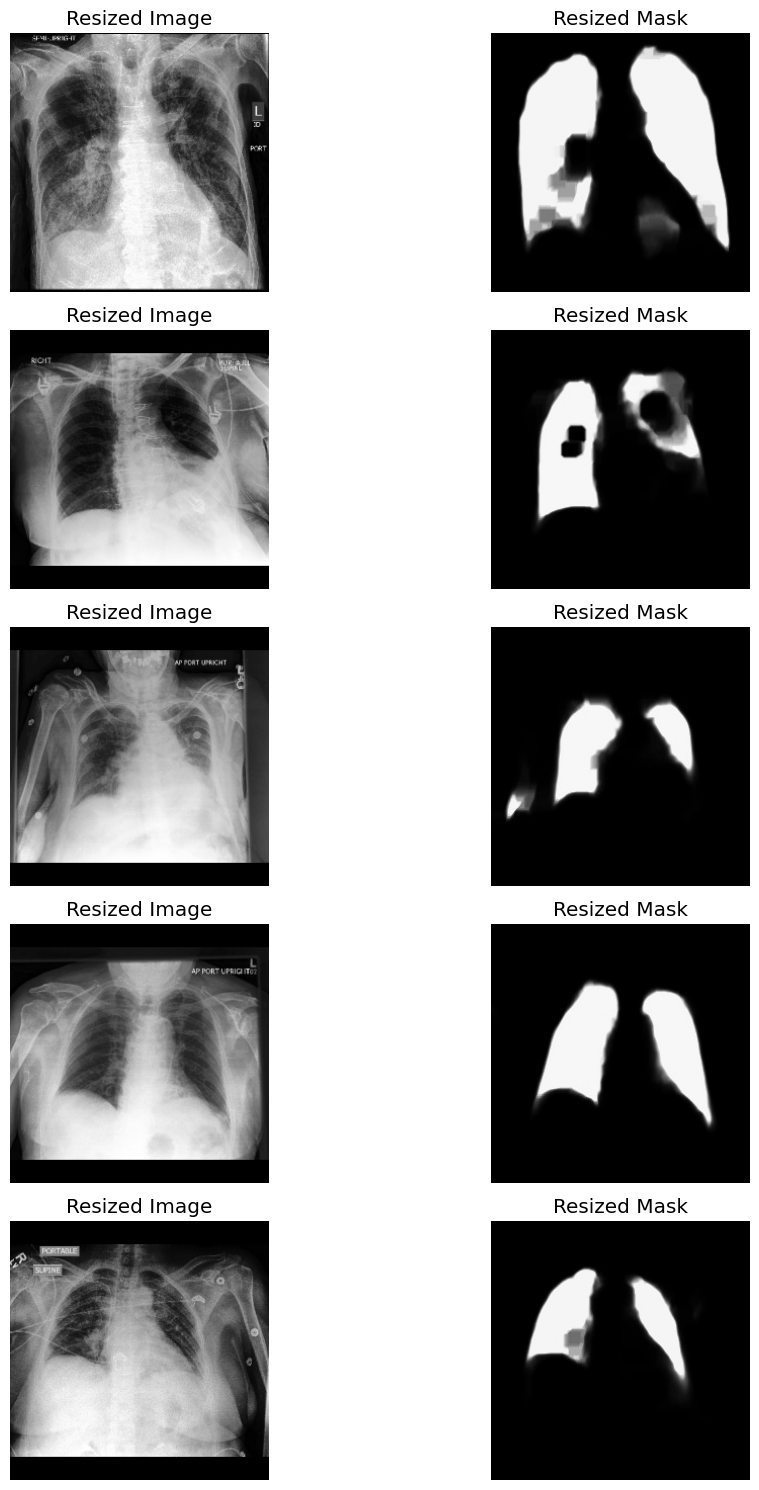

In [117]:
display_resized_samples(glob_valid_resize, mask_glob_valid, key_levels=3, num_samples=5)

[1] image: D:/Downloads/train_resized/patient27908/study2/view1_frontal.jpg
[1] key: patient27908/study2/view1_frontal
[1] mask: D:/Downloads/masks/train/patient27908/study2/view1_frontal_mask.jpg
[2] image: D:/Downloads/train_resized/patient35905/study15/view1_frontal.jpg
[2] key: patient35905/study15/view1_frontal
[2] mask: D:/Downloads/masks/train/patient35905/study15/view1_frontal_mask.jpg
[3] image: D:/Downloads/train_resized/patient10608/study4/view1_frontal.jpg
[3] key: patient10608/study4/view1_frontal
[3] mask: D:/Downloads/masks/train/patient10608/study4/view1_frontal_mask.jpg
[4] image: D:/Downloads/train_resized/patient20198/study34/view1_frontal.jpg
[4] key: patient20198/study34/view1_frontal
[4] mask: D:/Downloads/masks/train/patient20198/study34/view1_frontal_mask.jpg
[5] image: D:/Downloads/train_resized/patient05132/study3/view1_frontal.jpg
[5] key: patient05132/study3/view1_frontal
[5] mask: D:/Downloads/masks/train/patient05132/study3/view1_frontal_mask.jpg


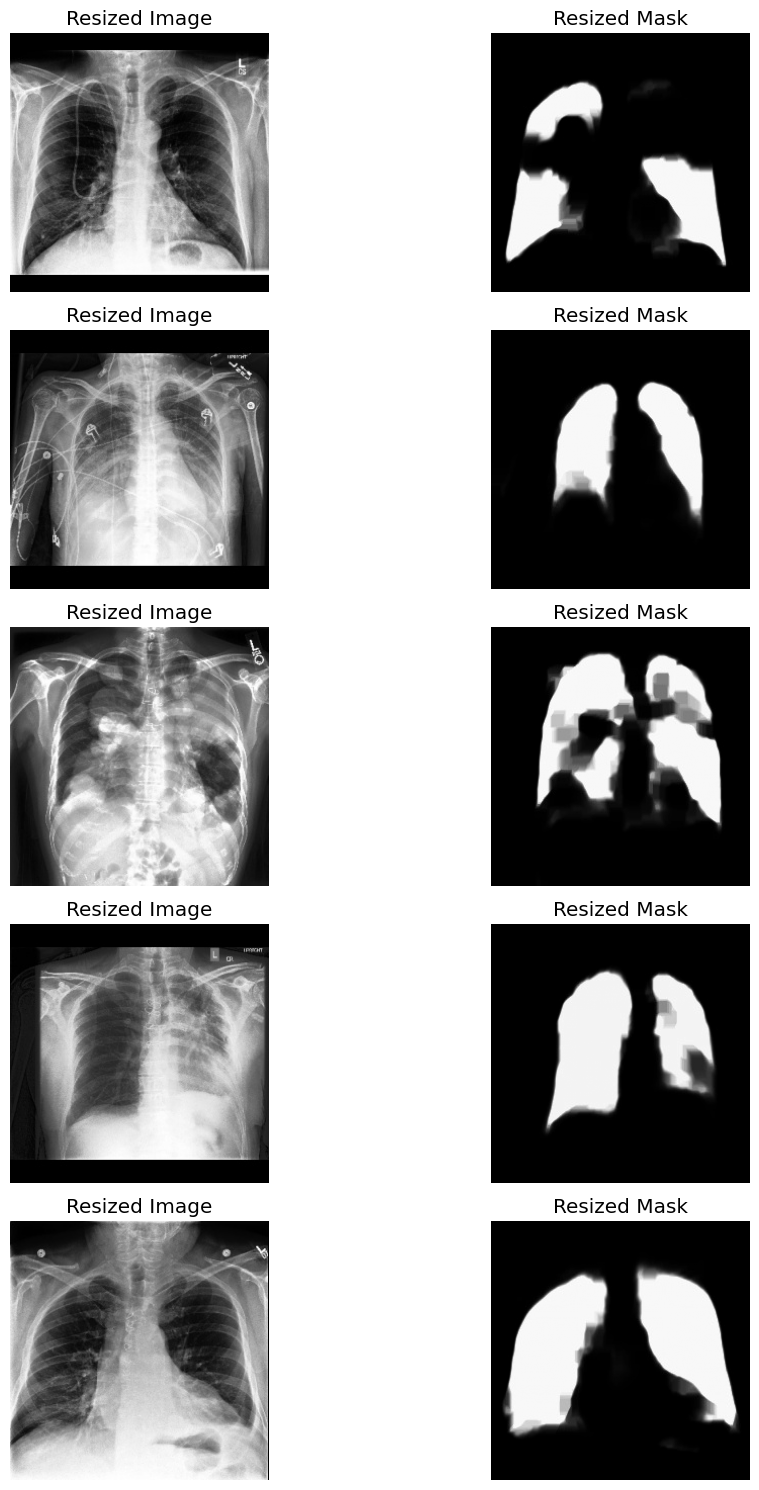

In [118]:
display_resized_samples(glob_train_resize, mask_glob_train, key_levels=3, num_samples=5)

# Combining Mask with Original Image

In [119]:
def convolutionize_mask(mask_glob, resize_glob, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    glob = []
    
    for mask_path, image_path in zip(mask_glob, resize_glob):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if mask is None or image is None:
            print(f"Failed to read mask or image: {mask_path}, {image_path}")
            continue
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Convert mask to weights 0–1
        mask_float = mask.astype("float32") / 255.0

        # Convolve the image with a Gaussian kernel
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Convolution-style combination
        result = image * mask_float + blurred * (1 - mask_float)
        result = np.clip(result, 0, 255).astype("uint8")
        
        # Build output path
        parts = image_path.replace("\\", "/").split("/")
        relative_path = "/".join(parts[3:])
        output_path = os.path.join(output_directory, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        directory, filename = os.path.split(output_path)
        name, ext = os.path.splitext(filename)
        new_filename = f"{name}_conv{ext}"
        output_path = os.path.join(directory, new_filename)
        
        # Save result
        success = cv2.imwrite(output_path, result)
        if success:
            print(f"✓ Saved: {output_path}")
            glob.append(output_path)
        else:
            print(f"✗ Failed to save: {output_path}")
    
    return glob


In [120]:
def check_convolutionized_images(mask_glob, img_glob, root_dir):
    valid_extensions = {".jpg", ".jpeg", ".png"}
    found = []
    os.makedirs(root_dir, exist_ok=True)

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            name, ext = os.path.splitext(file)
            if ext.lower() in valid_extensions and name.endswith("_conv"):
                found.append(os.path.join(root, file))
    
    if found:
        print(f"Found {len(found)} convolutionized images.")
        return found
    else:
        print("No convolutionized images found. Proceed to generate convolutionized images.")
        return convolutionize_mask(mask_glob, img_glob, root_dir)

In [121]:
conv_output_valid = "D:/Downloads/conv_valid"
conv_glob_valid = check_convolutionized_images(mask_glob_valid, glob_valid_resize, conv_output_valid)

Found 234 convolutionized images.


In [122]:
conv_output_train = "D:/Downloads/conv_train"
conv_glob_train = check_convolutionized_images(mask_glob_train, glob_train_resize, conv_output_train)

No convolutionized images found. Proceed to generate convolutionized images.
✓ Saved: D:/Downloads/conv_train\patient00006/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00012/study3\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00023/study6\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00039/study7\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00042/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00059/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00066/study1\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00067/study3\view2_lateral_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study17\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study27\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00069/study43\view1_frontal_conv.jpg
✓ Saved: D:/Downloads/conv_train\patient00081/study1\view2_frontal_conv.jpg
✓ Saved:

In [123]:
valid_df = replace_path(valid_df, conv_glob_valid)
valid_df

path  Atelectasis  \
0    D:/Downloads/conv_valid/patient64541/study1/vi...            0   
1    D:/Downloads/conv_valid/patient64542/study1/vi...            0   
2    D:/Downloads/conv_valid/patient64542/study1/vi...            0   
3    D:/Downloads/conv_valid/patient64543/study1/vi...            0   
4    D:/Downloads/conv_valid/patient64544/study1/vi...            1   
..                                                 ...          ...   
229  D:/Downloads/conv_valid/patient64736/study1/vi...            0   
230  D:/Downloads/conv_valid/patient64737/study1/vi...            1   
231  D:/Downloads/conv_valid/patient64738/study1/vi...            1   
232  D:/Downloads/conv_valid/patient64739/study1/vi...            1   
233  D:/Downloads/conv_valid/patient64740/study1/vi...            1   

     Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0               0              0      0                 0  
1               0              0      0                 1  
2               0              0      0                 0  
3               0              0      1                 0  
4               0              0      0                 1  
..            ...            ...    ...               ...  
229             0              0      1                 1  
230             0              0      0                 0  
231             0              0      0                 0  
232             1              1      1                 1  
233             0              0      0                 0  

[234 rows x 6 columns]

In [124]:
train_df = replace_path(train_df, conv_glob_train)
train_df.head()

path  Atelectasis  \
0  D:/Downloads/conv_train/patient00006/study1/vi...            0   
1  D:/Downloads/conv_train/patient00012/study3/vi...            0   
2  D:/Downloads/conv_train/patient00023/study6/vi...            0   
3  D:/Downloads/conv_train/patient00039/study7/vi...            0   
4  D:/Downloads/conv_train/patient00042/study1/vi...            1   

   Cardiomegaly  Consolidation  Edema  Pleural_Effusion  
0             0              0      0                 0  
1             0              0      0                 1  
2             0              0      0                 0  
3             0              0      1                 0  
4             0              0      0                 1

In [125]:
IMG_SIZE = (256,256)
CHANNELS = 3

In [126]:
base_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           shear_range=0.2,
                                                           zoom_range=0.2,
                                                           rotation_range=20,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           horizontal_flip=True)

train_gen = base_gen.flow_from_dataframe(dataframe=train_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle=True,
                                         batch_size=16)

valid_gen = base_gen.flow_from_dataframe(dataframe=valid_df,
                                         directory=None,
                                         x_col='path',
                                         y_col=class_names,
                                         class_mode='raw',
                                         target_size=IMG_SIZE,
                                         shuffle = True,
                                         batch_size=16)  


test_X, test_Y = next(base_gen.flow_from_dataframe(dataframe=valid_df,
                                                   directory=None,
                                                   x_col='path',
                                                   y_col=class_names,
                                                   class_mode='raw',
                                                   target_size=IMG_SIZE,
                                                   shuffle = True,
                                                   batch_size=16))

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 234 validated image filenames.


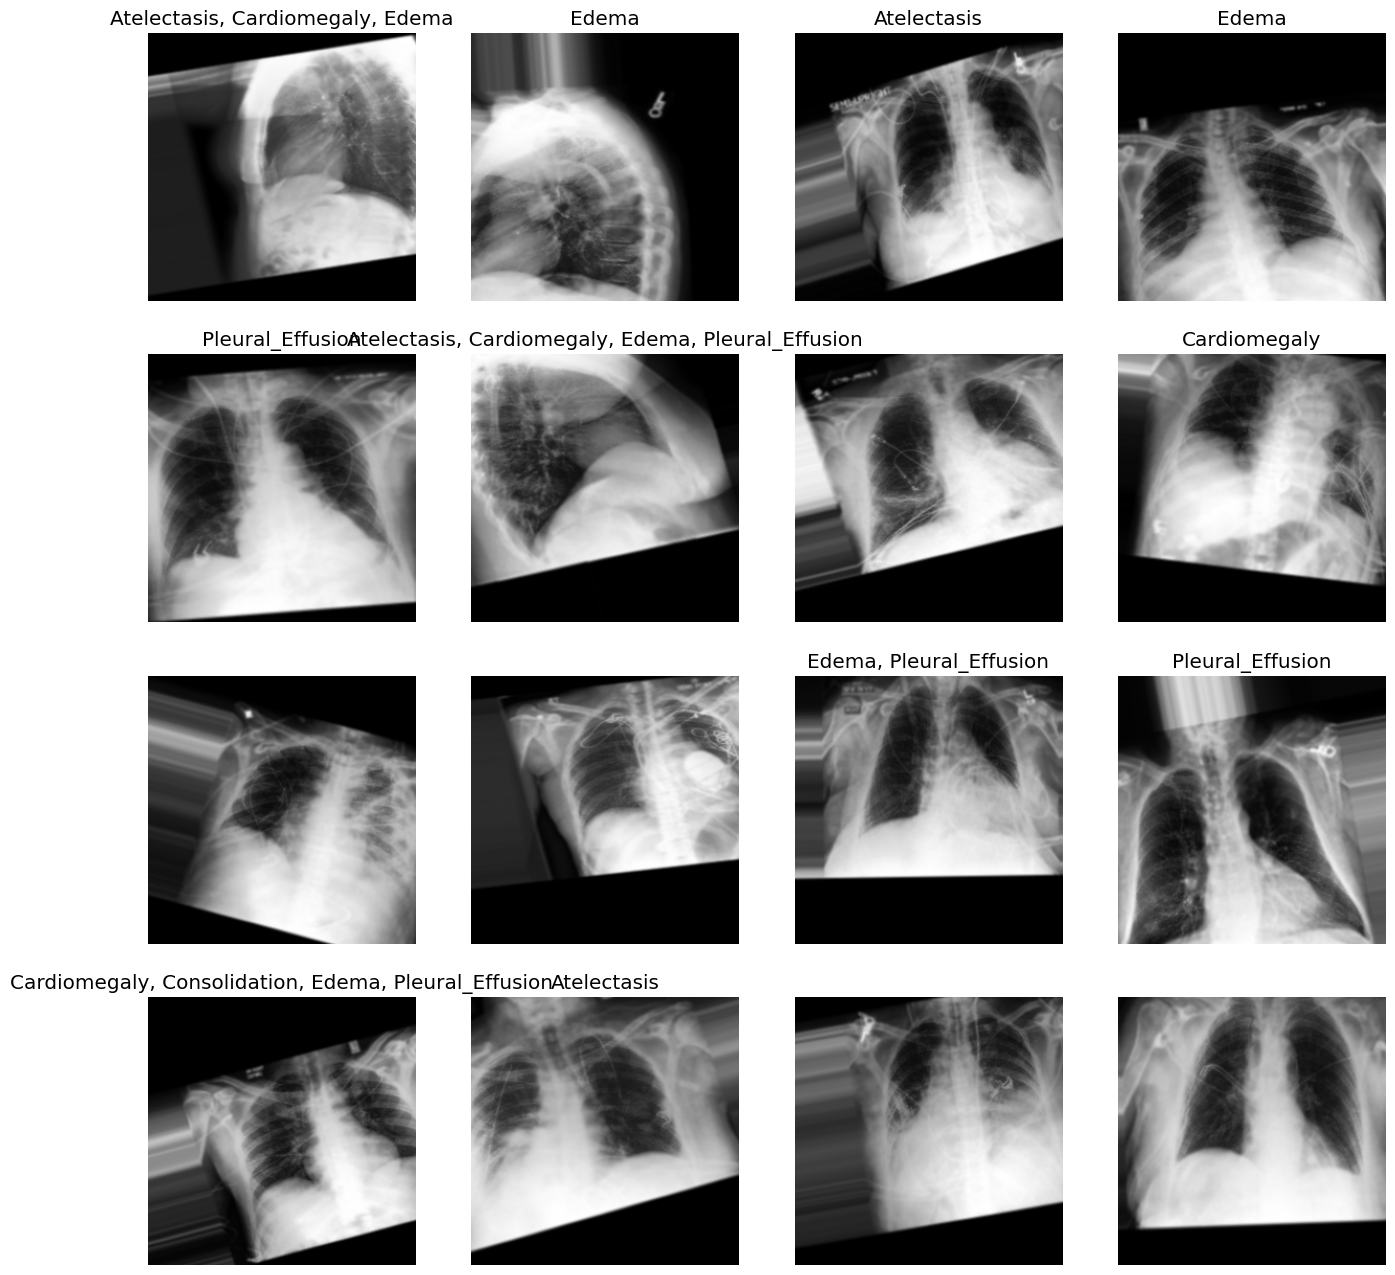

In [127]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,2], cmap='gray')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(class_names, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# DenseNet Model 

In [128]:
#model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output  
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(class_names), activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [129]:
@tf.function
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [130]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y = tf.cast(y, tf.float32)  
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1


In [131]:
#optimizer = tf.optimizers.RMSProp(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=3e-5, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
model.compile(optimizer=optimizer, loss=macro_soft_f1, metrics=[macro_f1])

In [134]:
print(len(valid_gen), "batches")

15 batches


In [ ]:
import time
print("Cell executed at:", time.time())
H = model.fit(train_gen,validation_data=(test_X,test_Y),epochs=3)

Cell executed at: 1765171333.5200453
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 481ms/step - loss: 0.6555 - macro_f1: 0.3453 - val_loss: 0.6740 - val_macro_f1: 0.3262
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 282s 452ms/step - loss: 0.6546 - macro_f1: 0.3457 - val_loss: 0.6739 - val_macro_f1: 0.3262
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 441ms/step - loss: 0.6548 - macro_f1: 0.3453 - val_loss: 0.6739 - val_macro_f1: 0.3262
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 447ms/step - loss: 0.6543 - macro_f1: 0.3459 - val_loss: 0.6739 - val_macro_f1: 0.3262
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 282s 451ms/step - loss: 0.6549 - macro_f1: 0.3452 - val_loss: 0.6739 - val_macro_f1: 0.3262
Epoch 6/10
498/625 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - loss: 0.6558 - macro_f1: 0.3442

KeyboardInterrupt: 

In [ ]:
model.save('DenseNet121.h5')

In [ ]:
def learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

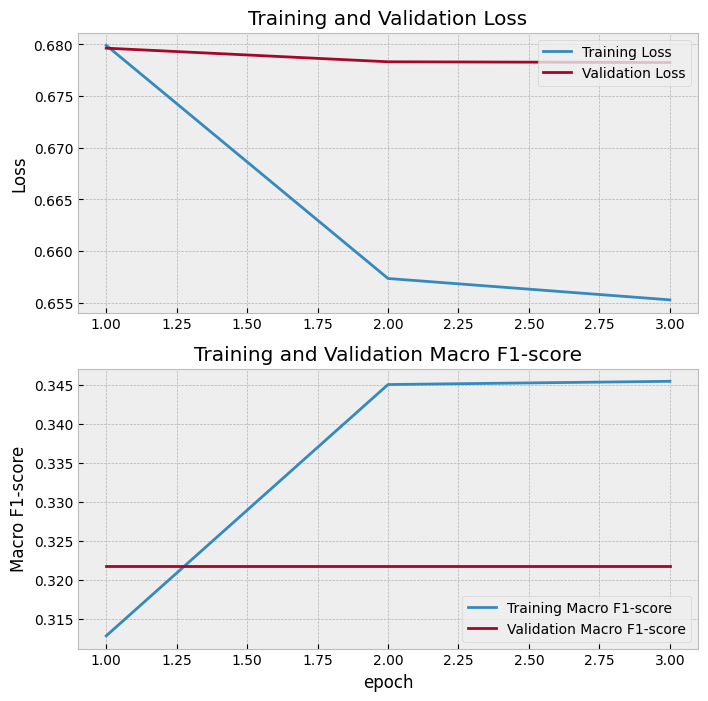

In [ ]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(H)

In [ ]:
print("Macro soft-F1 loss: %.2f" %val_losses[-1])
print("Macro F1-score: %.2f" %val_macro_f1s[-1])

Macro soft-F1 loss: 0.68
Macro F1-score: 0.32


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import math

# Confusion matrices + heatmaps for multilabel DenseNet121 model on validation set
# ensure deterministic order for evaluation
BATCH_SIZE = 16
thresh = 0.5

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# predict probabilities for the whole validation set
preds = model.predict(valid_eval_gen, verbose=0)
y_true = valid_df[class_names].to_numpy()
y_pred = (preds >= thresh).astype(int)

# overall multilabel reports
print("Classification report (per-class):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

print("Macro F1 (sklearn):", f1_score(y_true, y_pred, average='macro'))
print("Micro F1 (sklearn):", f1_score(y_true, y_pred, average='micro'))

# Plot 2x2 confusion matrix heatmaps for each class
n = len(class_names)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=[0,1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
                ax=axes[i])
    axes[i].set_title(f"{cls} (Thresh={thresh})")
    axes[i].set_ylabel("True")
    axes[i].set_xlabel("Predicted")

# hide any unused subplots
for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Found 0 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 234 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step

AUC per class:
Atelectasis: 0.4674
Cardiomegaly: 0.5130
Consolidation: 0.4174
Edema: 0.5122
Pleural_Effusion: 0.5050

Macro AUC: 0.4829729969715656
Micro AUC: 0.6689752555137171


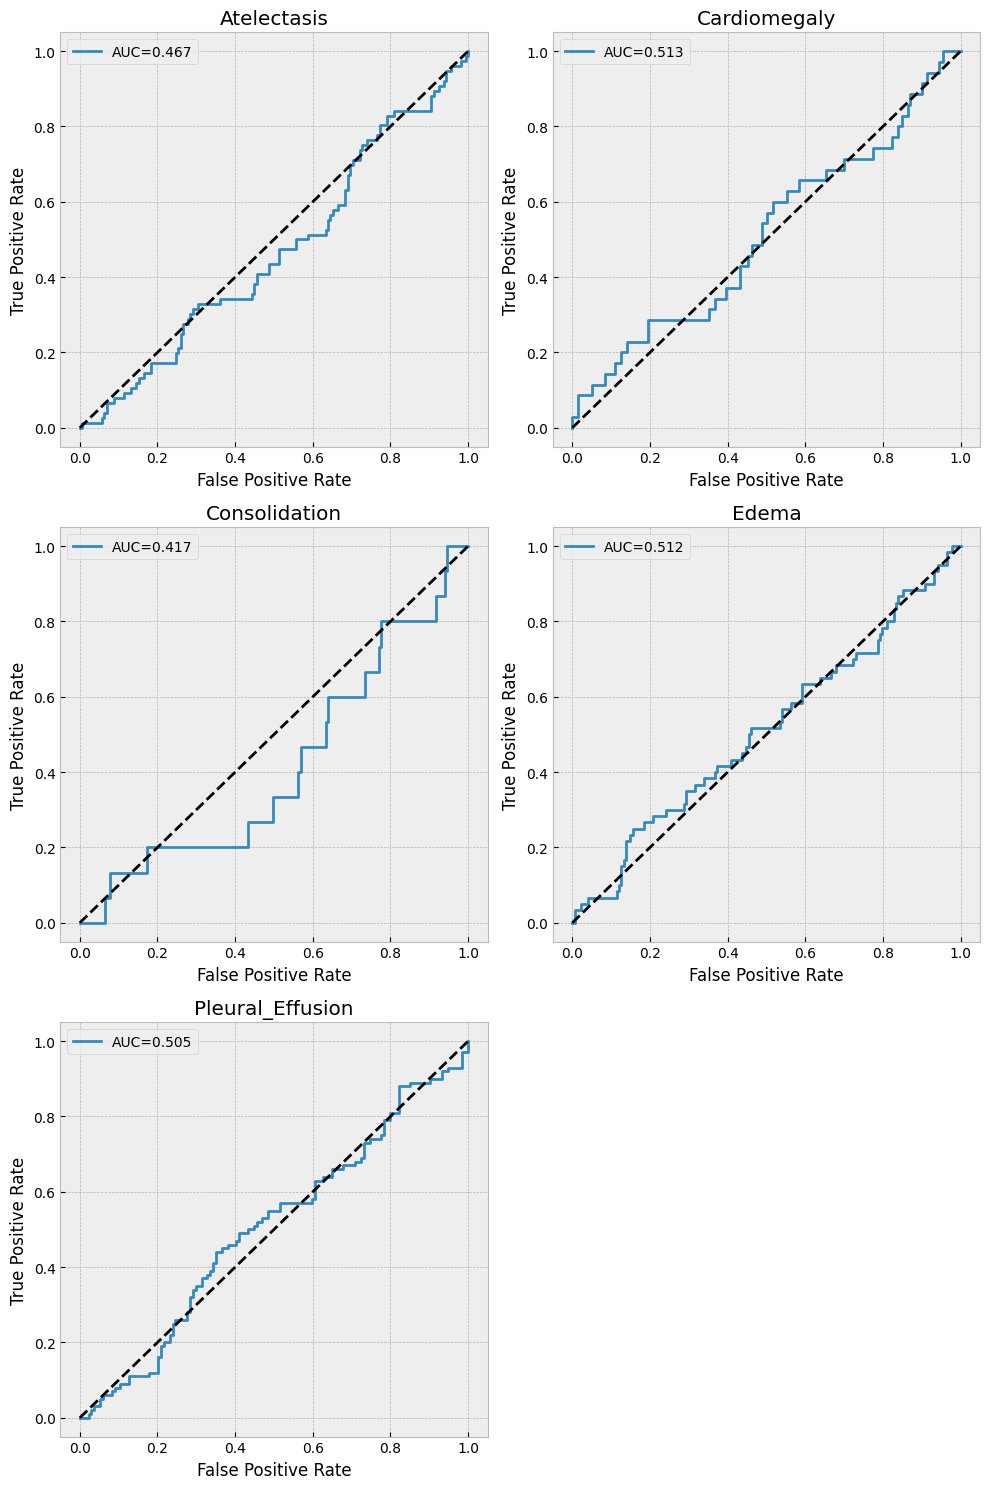

In [ ]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


# CNN Model

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 10000 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 358s 570ms/step - loss: 0.7091 - macro_f1: 0.2945 - val_loss: 0.6782 - val_macro_f1: 0.3218
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 358s 570ms/step - loss: 0.7091 - macro_f1: 0.2945 - val_loss: 0.6782 - val_macro_f1: 0.3218
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - loss: 0.6960 - macro_f1: 0.3100 - val_loss: 0.6782 - val_macro_f1: 0.3218
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - loss: 0.6960 - macro_f1: 0.3100 - val_loss: 0.6782 - val_macro_f1: 0.3218
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - loss: 0.6893 - macro_f1: 0.3162 - val_loss: 0.6782 - val_macro_f1: 0.3218
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - loss: 0.6893 - macro_f1: 0.3162 - val_loss: 0.6782 - val_macro_f1: 0.3218


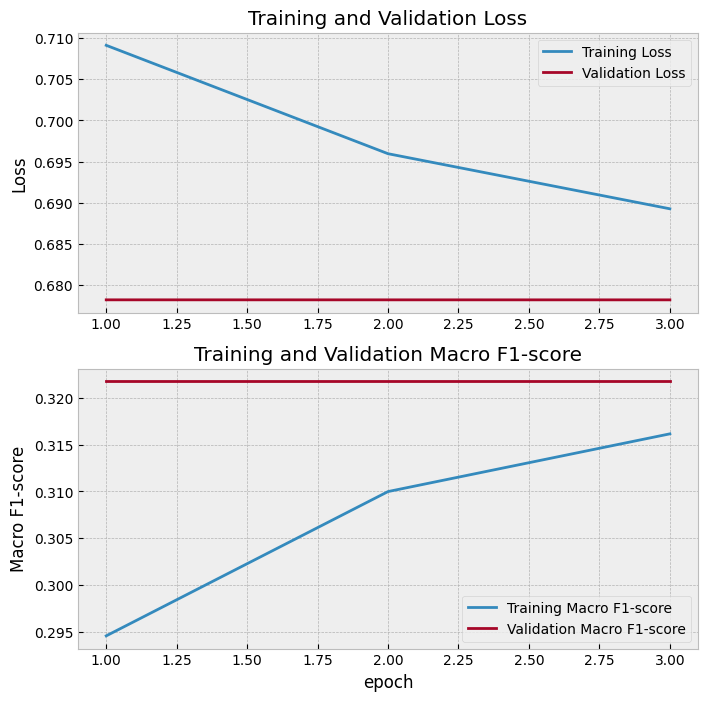

CNN Macro soft-F1 loss: 0.68
CNN Macro F1-score: 0.32


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten


def build_simple_cnn(input_shape=(256,256,3), n_classes=len(class_names)):
    """Return a small CNN for multi-label classification."""
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='sigmoid'))
    return model


# Build, compile and train the CNN
cnn_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
cnn_model = build_simple_cnn(input_shape=cnn_input_shape, n_classes=len(class_names))
cnn_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-5),
                  loss=macro_soft_f1, metrics=[macro_f1])

# Recreate deterministic generator for validation and test to keep ordering stable
cnn_valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)

cnn_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

# Use test_X and test_Y that were created earlier as a small validation set for consistent behavior
H_cnn = cnn_model.fit(cnn_train_gen, validation_data=(test_X, test_Y), epochs=3)
cnn_model.save('simple_cnn.h5')


# Learning curves for CNN
losses_c, val_losses_c, macro_f1s_c, val_macro_f1s_c = learning_curves(H_cnn)
print("CNN Macro soft-F1 loss: %.2f" % val_losses_c[-1])
print("CNN Macro F1-score: %.2f" % val_macro_f1s_c[-1])

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step
CNN Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15      1.00      0.26        35
   Consolidation       0.06      1.00      0.12        15
           Edema       0.26      1.00      0.41        60
Pleural_Effusion       0.43      1.00      0.60       100

       micro avg       0.24      1.00      0.39       286
       macro avg       0.24      1.00      0.38       286
    weighted avg       0.31      1.00      0.46       286
     samples avg       0.24      0.72      0.35       286

CNN Macro F1 (sklearn): 0.3755986434397691
CNN Micro F1 (sklearn): 0.39285714285714285
CNN Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15      1.00      0.26      

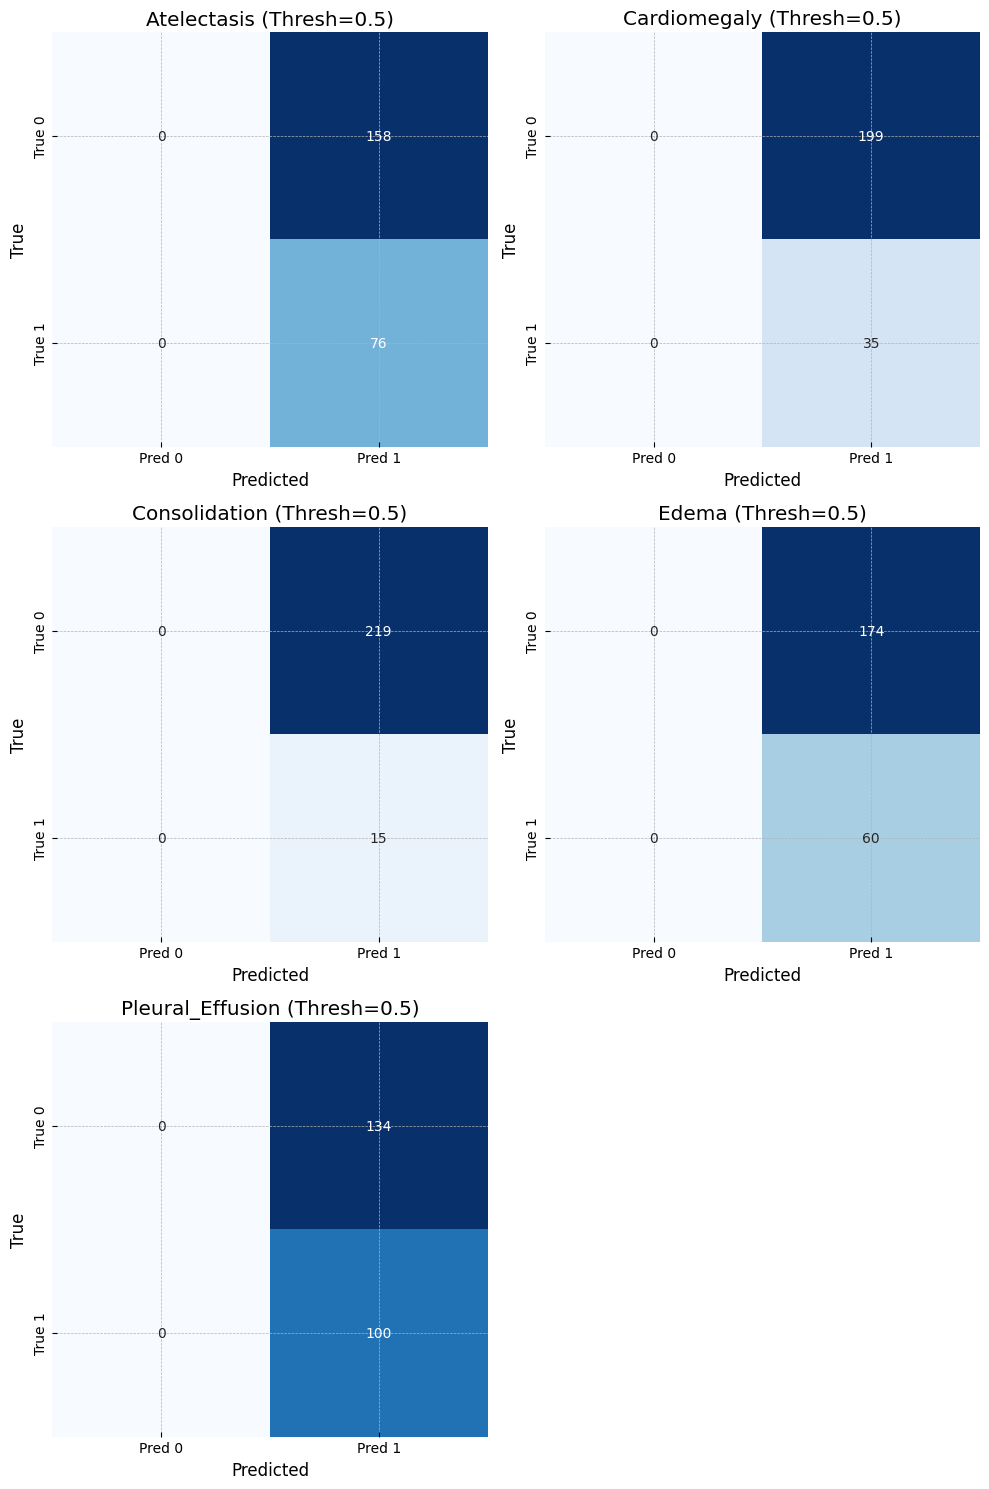


CNN AUC per class:
Atelectasis: 0.5244
Cardiomegaly: 0.5068
Consolidation: 0.5353
Edema: 0.4509
Pleural_Effusion: 0.4806

CNN Macro AUC: 0.4996065920474786
CNN Micro AUC: 0.5547198841882099


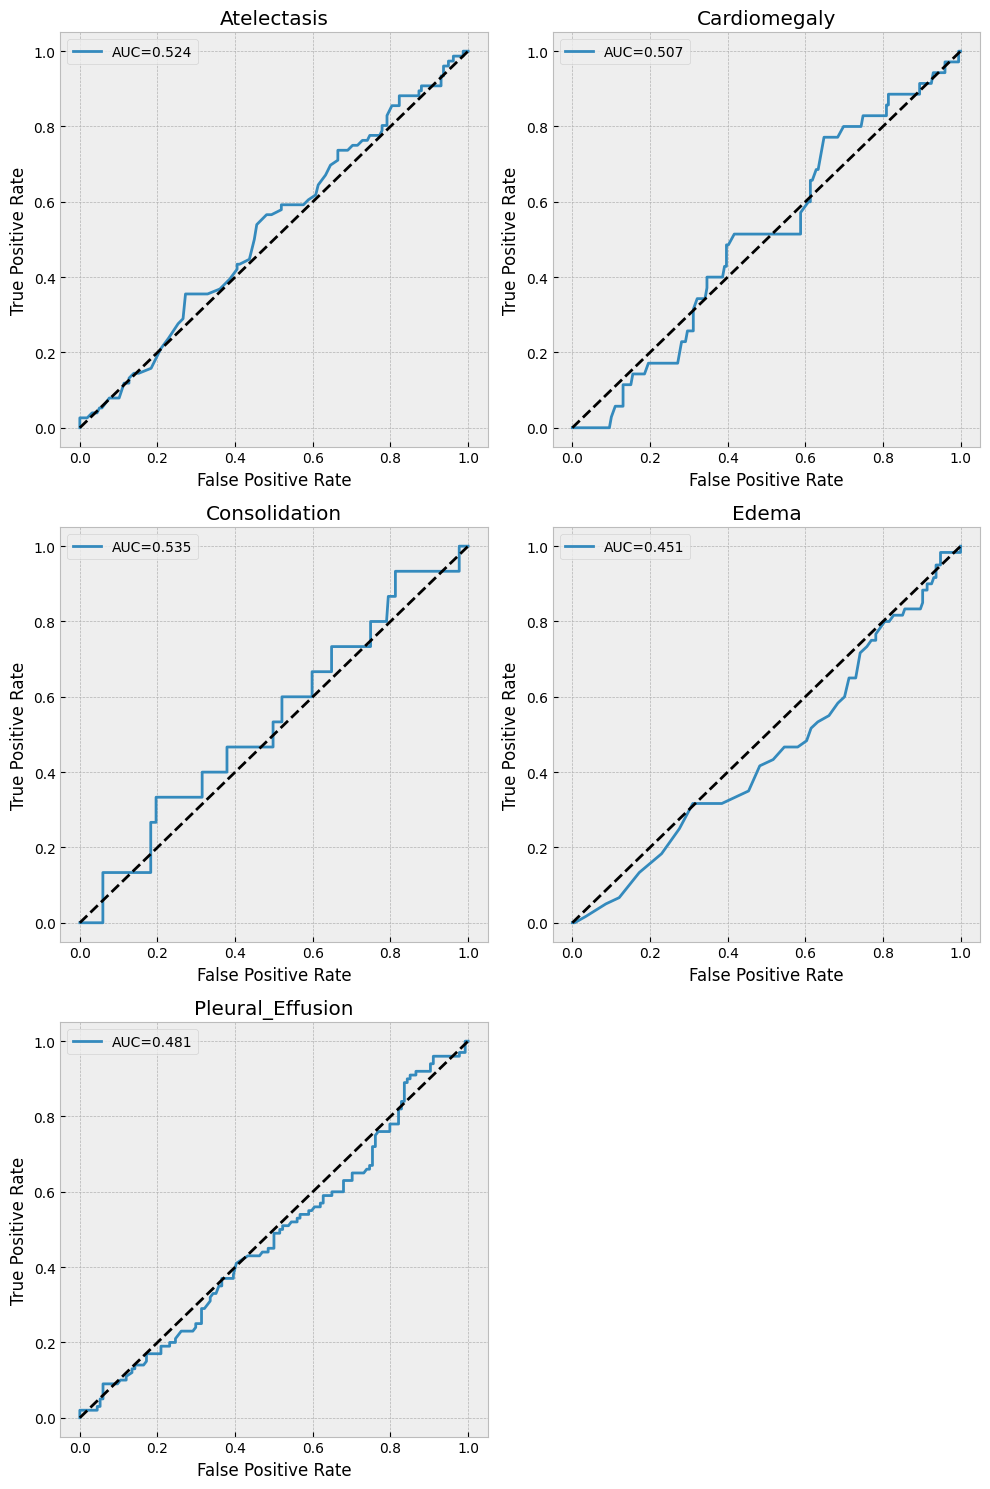

In [ ]:
# Evaluate CNN on the full validation set with deterministic ordering and compute statistics
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

BATCH_SIZE = 16
thresh_cnn = 0.5

valid_eval_gen_cnn = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

preds_cnn = cnn_model.predict(valid_eval_gen_cnn, verbose=1)
y_true_cnn = valid_df[class_names].to_numpy()
y_pred_cnn = (preds_cnn >= thresh_cnn).astype(int)

print("CNN Classification report (per-class):")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names, zero_division=0))
print("CNN Macro F1 (sklearn):", f1_score(y_true_cnn, y_pred_cnn, average='macro'))
print("CNN Micro F1 (sklearn):", f1_score(y_true_cnn, y_pred_cnn, average='micro'))

# Confusion heatmaps per class
import math as _math
n = len(class_names)
cols = 2
rows = _math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    cm = confusion_matrix(y_true_cnn[:, i], y_pred_cnn[:, i], labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=axes[i])
    axes[i].set_title(f"{cls} (Thresh={thresh_cnn})")
    axes[i].set_ylabel('True')
    axes[i].set_xlabel('Predicted')

for j in range(n, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# ROC AUC per class for CNN
auc_per_class_cnn = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true_cnn[:, i], preds_cnn[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class_cnn[cls] = auc

print('\nCNN AUC per class:')
for cls, auc in auc_per_class_cnn.items():
    print(f"{cls}: {auc:.4f}")

try:
    macro_auc_cnn = roc_auc_score(y_true_cnn, preds_cnn, average='macro')
except ValueError:
    macro_auc_cnn = float('nan')
try:
    micro_auc_cnn = roc_auc_score(y_true_cnn, preds_cnn, average='micro')
except ValueError:
    micro_auc_cnn = float('nan')

print('\nCNN Macro AUC:', macro_auc_cnn)
print('CNN Micro AUC:', micro_auc_cnn)

# ROC curves
cols = 2
rows = _math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()
for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true_cnn[:, i], preds_cnn[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class_cnn[cls]:.3f}")
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis('off')

for j in range(len(class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 463ms/step

AUC per class:
Atelectasis: 0.5235
Cardiomegaly: 0.5309
Consolidation: 0.4661
Edema: 0.5119
Pleural_Effusion: 0.5115

Macro AUC: 0.5087705061496796
Micro AUC: 0.6788694902382685

AUC per class:
Atelectasis: 0.5235
Cardiomegaly: 0.5309
Consolidation: 0.4661
Edema: 0.5119
Pleural_Effusion: 0.5115

Macro AUC: 0.5087705061496796
Micro AUC: 0.6788694902382685


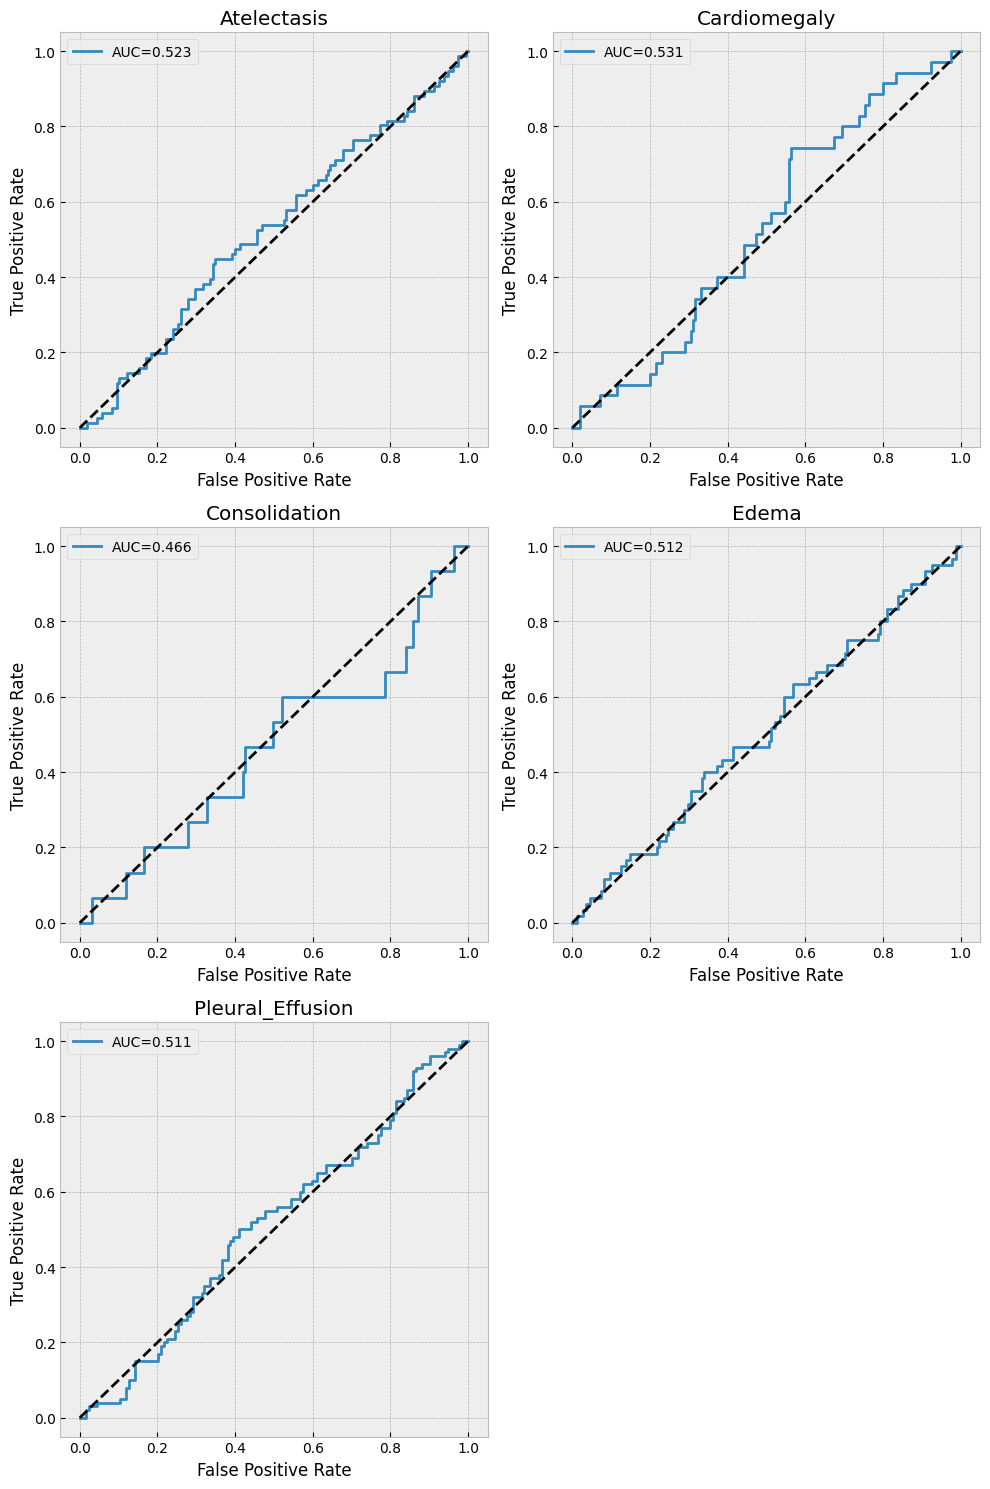

In [ ]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# ResNet-50

Found 10000 validated image filenames.
Found 234 validated image filenames.
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 280s 442ms/step - loss: 0.6750 - macro_f1: 0.3120 - val_loss: 0.6801 - val_macro_f1: 0.3218
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 280s 442ms/step - loss: 0.6750 - macro_f1: 0.3120 - val_loss: 0.6801 - val_macro_f1: 0.3218
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 435ms/step - loss: 0.6552 - macro_f1: 0.3453 - val_loss: 0.6783 - val_macro_f1: 0.3218
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 435ms/step - loss: 0.6552 - macro_f1: 0.3453 - val_loss: 0.6783 - val_macro_f1: 0.3218
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 290s 463ms/step - loss: 0.6545 - macro_f1: 0.3456 - val_loss: 0.6783 - val_macro_f1: 0.3218
625/625 ━━━━━━━━━━━━━━━━━━━━ 290s 463ms/step - loss: 0.6545 - macro_f1: 0.3456 - val_loss: 0.6783 - val_macro_f1: 0.3218


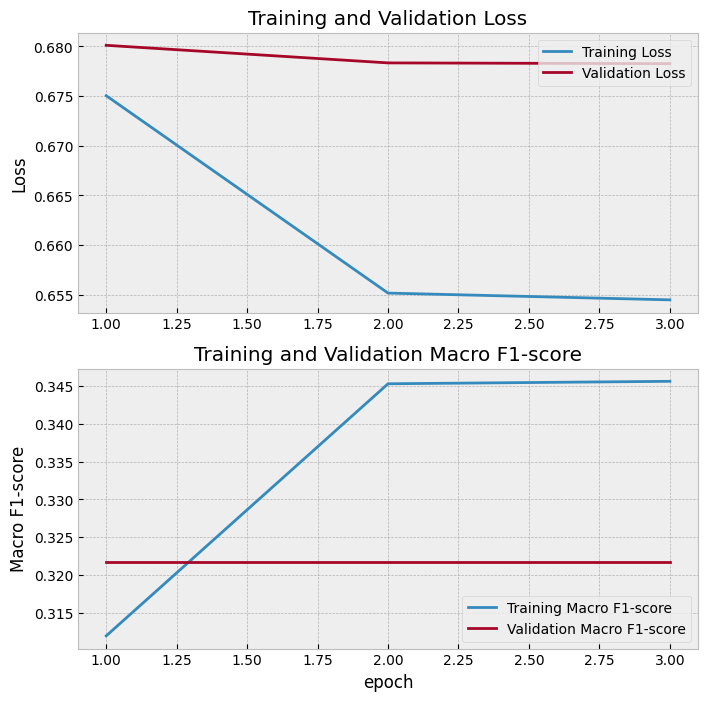

ResNet50 Macro soft-F1 loss: 0.68
ResNet50 Macro F1-score: 0.32


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step
ResNet50 Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15      1.00      0.26        35
   Consolidation       0.06      1.00      0.12        15
           Edema       0.26      1.00      0.41        60
Pleural_Effusion       0.43      1.00      0.60       100

       micro avg       0.24      1.00      0.39       286
       macro avg       0.24      1.00      0.38       286
    weighted avg       0.31      1.00      0.46       286
     samples avg       0.24      0.72      0.35       286

ResNet50 Macro F1 (sklearn): 0.3755986434397691
ResNet50 Micro F1 (sklearn): 0.39285714285714285
ResNet50 Classification report (per-class):
                  precision    recall  f1-score   support

     Atelectasis       0.32      1.00      0.49        76
    Cardiomegaly       0.15    

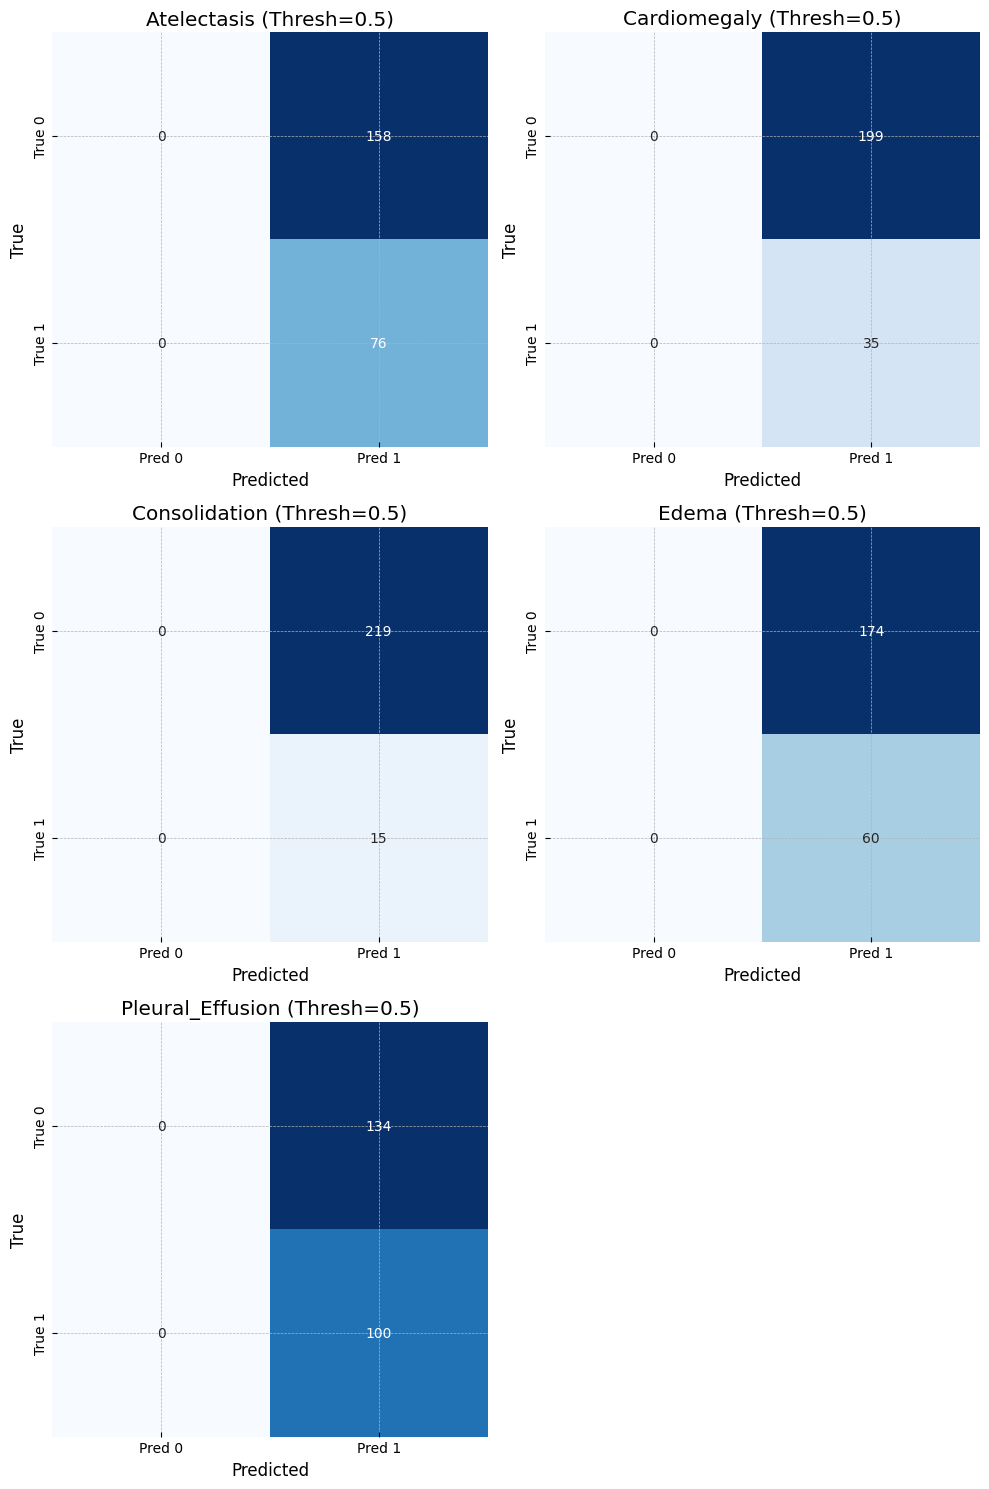


ResNet50 AUC per class:
Atelectasis: 0.4777
Cardiomegaly: 0.5580
Consolidation: 0.5820
Edema: 0.5004
Pleural_Effusion: 0.4860

ResNet50 Macro AUC: 0.5208253220887334
ResNet50 Micro AUC: 0.6895211688763725


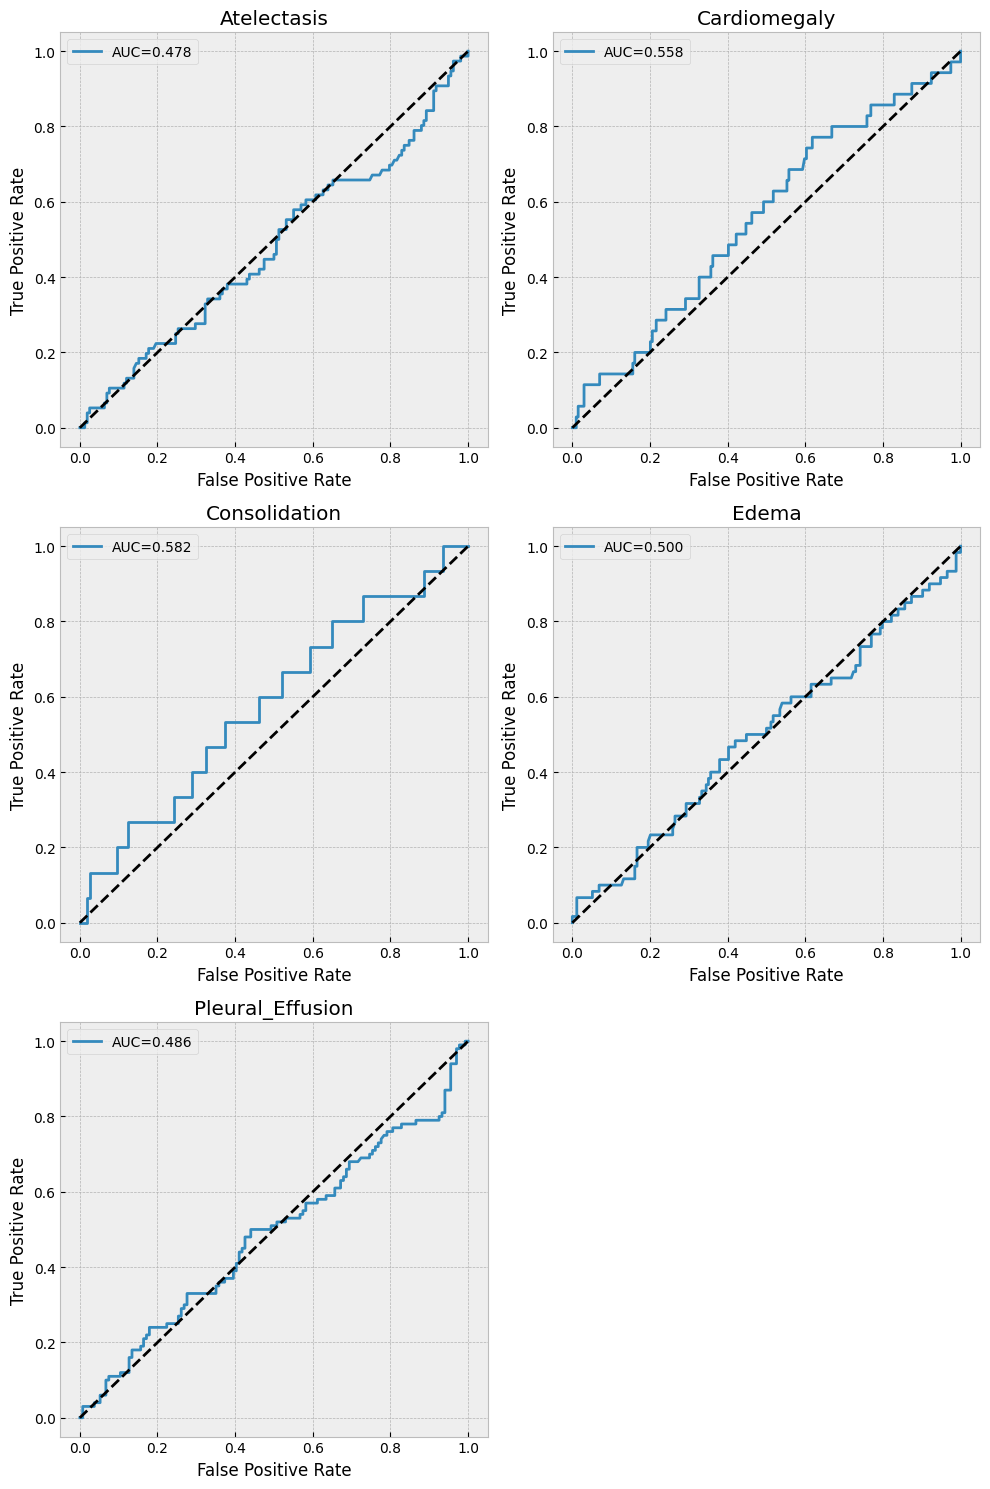

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_resnet50(input_shape=(256,256,3), n_classes=len(class_names), trainable=False):
    """Build a ResNet50 base with a simple classification head for multi-label tasks."""
    base_model_r = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_r.trainable = trainable  # freeze by default
    x = base_model_r.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(n_classes, activation='sigmoid')(x)
    model_r = tf.keras.models.Model(inputs=base_model_r.input, outputs=outputs)
    return model_r


# Build, compile and train ResNet50
resnet_input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
resnet_model = build_resnet50(input_shape=resnet_input_shape, n_classes=len(class_names), trainable=False)
resnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-5),
                     loss=macro_soft_f1, metrics=[macro_f1])

# Use the same generators, ensuring deterministic evaluation generator
resnet_train_gen = base_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

resnet_valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=16
)

# Train for the same number of epochs; using the test_X/test_Y as a quick validation set
H_resnet = resnet_model.fit(resnet_train_gen, validation_data=(test_X, test_Y), epochs=3)
resnet_model.save('ResNet50.h5')

# Learning curves for ResNet
losses_r, val_losses_r, macro_f1s_r, val_macro_f1s_r = learning_curves(H_resnet)
print("ResNet50 Macro soft-F1 loss: %.2f" % val_losses_r[-1])
print("ResNet50 Macro F1-score: %.2f" % val_macro_f1s_r[-1])


# Evaluate ResNet50 on the full validation set and compute metrics (same as before)
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve

BATCH_SIZE = 16
thresh_resnet = 0.5

resnet_preds = resnet_model.predict(resnet_valid_eval_gen, verbose=1)
y_true_r = valid_df[class_names].to_numpy()
y_pred_r = (resnet_preds >= thresh_resnet).astype(int)

print("ResNet50 Classification report (per-class):")
print(classification_report(y_true_r, y_pred_r, target_names=class_names, zero_division=0))
print("ResNet50 Macro F1 (sklearn):", f1_score(y_true_r, y_pred_r, average='macro'))
print("ResNet50 Micro F1 (sklearn):", f1_score(y_true_r, y_pred_r, average='micro'))

# Confusion heatmaps per class for ResNet50
cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()
for i, cls in enumerate(class_names):
    cm = confusion_matrix(y_true_r[:, i], y_pred_r[:, i], labels=[0, 1])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=axes[i])
    axes[i].set_title(f"{cls} (Thresh={thresh_resnet})")
    axes[i].set_ylabel('True')
    axes[i].set_xlabel('Predicted')
for j in range(len(class_names), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# AUC per class for ResNet50
auc_per_class_resnet = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true_r[:, i], resnet_preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class_resnet[cls] = auc

print('\nResNet50 AUC per class:')
for cls, auc in auc_per_class_resnet.items():
    print(f"{cls}: {auc:.4f}")

try:
    macro_auc_r = roc_auc_score(y_true_r, resnet_preds, average='macro')
except ValueError:
    macro_auc_r = float('nan')
try:
    micro_auc_r = roc_auc_score(y_true_r, resnet_preds, average='micro')
except ValueError:
    micro_auc_r = float('nan')

print('\nResNet50 Macro AUC:', macro_auc_r)
print('ResNet50 Micro AUC:', micro_auc_r)

# ROC curves for ResNet50
cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()
for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true_r[:, i], resnet_preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class_resnet[cls]:.3f}")
        axes[i].plot([0, 1], [0, 1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel('False Positive Rate')
        axes[i].set_ylabel('True Positive Rate')
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis('off')
for j in range(len(class_names), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step

AUC per class:
Atelectasis: 0.4479
Cardiomegaly: 0.4856
Consolidation: 0.5976
Edema: 0.5023
Pleural_Effusion: 0.4815

Macro AUC: 0.5029515122137336
Micro AUC: 0.6613375312470335

AUC per class:
Atelectasis: 0.4479
Cardiomegaly: 0.4856
Consolidation: 0.5976
Edema: 0.5023
Pleural_Effusion: 0.4815

Macro AUC: 0.5029515122137336
Micro AUC: 0.6613375312470335


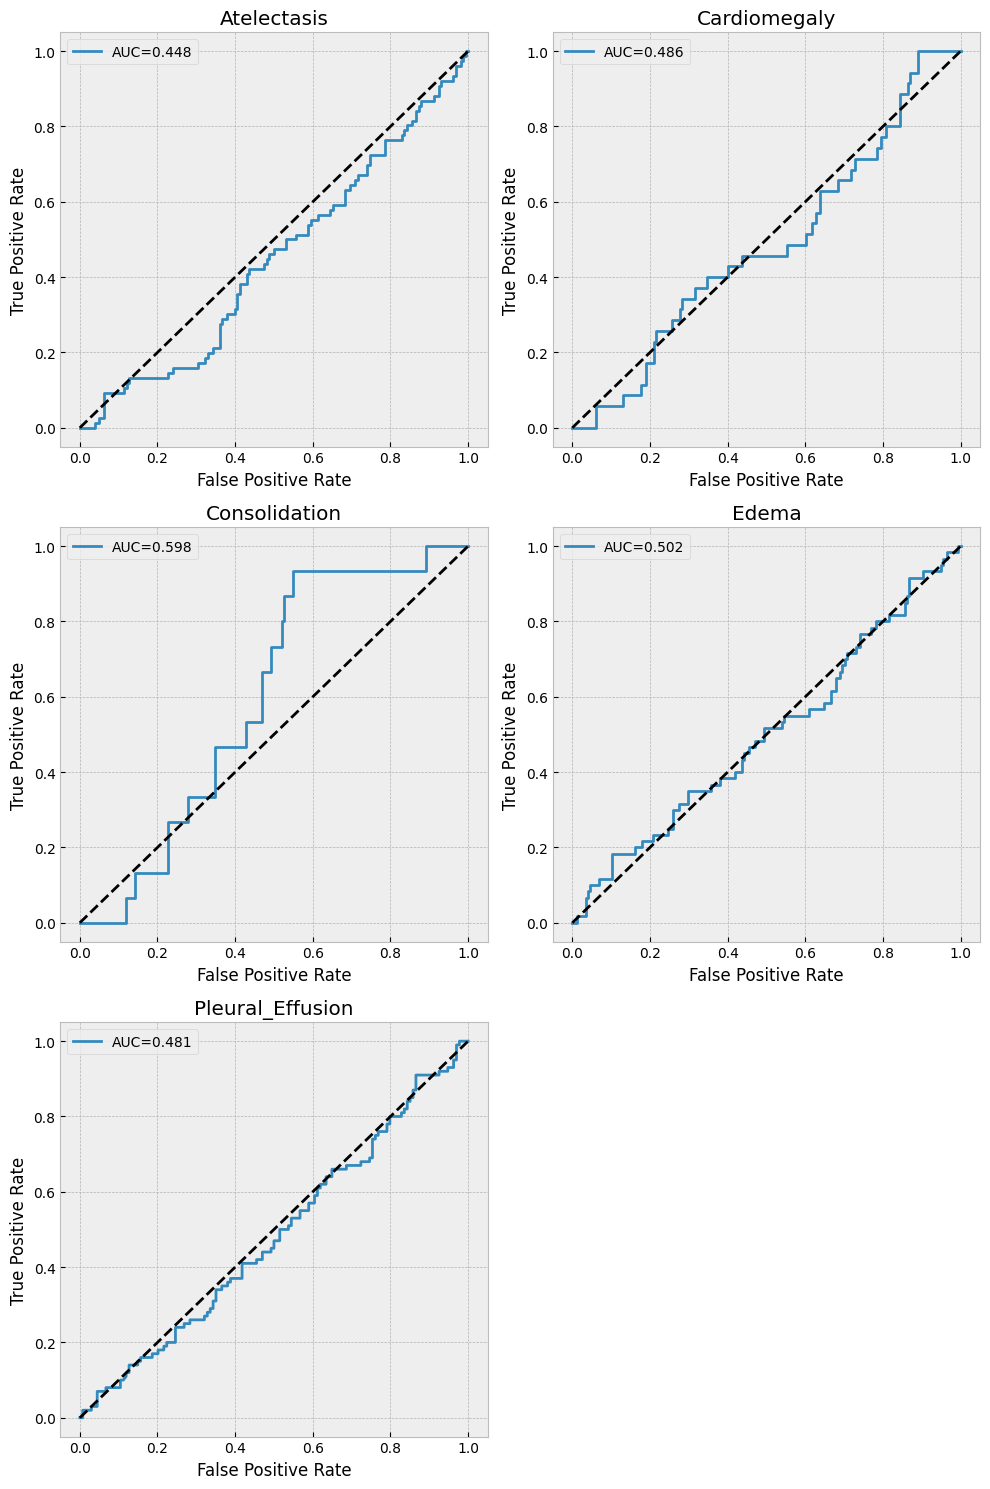

In [ ]:
from sklearn.metrics import roc_auc_score
import math

# deterministic validation generator
BATCH_SIZE = 16

valid_eval_gen = base_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='path',
    y_col=class_names,
    class_mode='raw',
    target_size=IMG_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# get prediction probabilities
preds = model.predict(valid_eval_gen, verbose=1)
y_true = valid_df[class_names].to_numpy()

# compute AUC per class
auc_per_class = {}
for i, cls in enumerate(class_names):
    try:
        auc = roc_auc_score(y_true[:, i], preds[:, i])
    except ValueError:
        auc = float('nan')
    auc_per_class[cls] = auc

print("\nAUC per class:")
for cls, auc in auc_per_class.items():
    print(f"{cls}: {auc:.4f}")

# macro and micro AUC
try:
    macro_auc = roc_auc_score(y_true, preds, average='macro')
except ValueError:
    macro_auc = float('nan')

try:
    micro_auc = roc_auc_score(y_true, preds, average='micro')
except ValueError:
    micro_auc = float('nan')

print("\nMacro AUC:", macro_auc)
print("Micro AUC:", micro_auc)

# optional: plot ROC curves for each class
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

cols = 2
rows = math.ceil(len(class_names) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    try:
        fpr, tpr, _ = roc_curve(y_true[:, i], preds[:, i])
        axes[i].plot(fpr, tpr, label=f"AUC={auc_per_class[cls]:.3f}")
        axes[i].plot([0,1], [0,1], 'k--')
        axes[i].set_title(cls)
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].legend()
    except ValueError:
        axes[i].set_title(f"{cls} (no positives)")
        axes[i].axis("off")

# hide unused plots
for j in range(len(class_names), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model_for_comparison(model, model_name, history, valid_df, base_gen, target_size, class_names, thresh=0.5, batch_size=16):
    """Evaluate a model and return metrics summary used for cross-model comparisons.

    Returns a dict containing per-class AUCs, macro/micro AUCs, final training & validation macro-F1
    values, the classification report, confusion matrices for each class and the history arrays.
    """
    # Deterministic generator for validation
    eval_gen = base_gen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='path',
        y_col=class_names,
        class_mode='raw',
        target_size=target_size,
        shuffle=False,
        batch_size=batch_size
    )

    # Prediction probabilities
    preds = model.predict(eval_gen, verbose=1)
    y_true = valid_df[class_names].to_numpy()
    y_pred_bin = (preds >= thresh).astype(int)

    # Classification report & F1s
    report = classification_report(y_true, y_pred_bin, target_names=class_names, zero_division=0, output_dict=True)
    sk_macro_f1 = None
    sk_micro_f1 = None
    try:
        sk_macro_f1 = f1_score(y_true, y_pred_bin, average='macro')
        sk_micro_f1 = f1_score(y_true, y_pred_bin, average='micro')
    except Exception:
        sk_macro_f1 = float('nan')
        sk_micro_f1 = float('nan')
    macro_f1_train = None
    macro_f1_val = None
    if history is not None and hasattr(history, 'history'):
        hist = history.history
        macro_f1_train = hist.get('macro_f1', [None])[-1]
        macro_f1_val = hist.get('val_macro_f1', [None])[-1]

    # Per-class confusion matrices
    cm_per_class = {}
    for i, cls in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred_bin[:, i], labels=[0, 1])
        cm_per_class[cls] = cm

    # AUC per class
    auc_per_class = {}
    for i, cls in enumerate(class_names):
        try:
            auc = roc_auc_score(y_true[:, i], preds[:, i])
        except Exception:
            auc = float('nan')
        auc_per_class[cls] = auc

    try:
        macro_auc = roc_auc_score(y_true, preds, average='macro')
    except Exception:
        macro_auc = float('nan')
    try:
        micro_auc = roc_auc_score(y_true, preds, average='micro')
    except Exception:
        micro_auc = float('nan')

    return {
        'model_name': model_name,
        'preds': preds,
        'y_true': y_true,
        'y_pred_bin': y_pred_bin,
        'report': report,
        'cm_per_class': cm_per_class,
        'auc_per_class': auc_per_class,
        'macro_auc': macro_auc,
        'micro_auc': micro_auc,
        'macro_f1_train': macro_f1_train,
        'macro_f1_val': macro_f1_val,
        'sk_macro_f1': sk_macro_f1,
        'sk_micro_f1': sk_micro_f1,
        'history': history
    }

In [ ]:
def compare_models_and_report(models_info, class_names, out_csv='model_comparison.csv'):
    """Given a list of evaluation dictionaries (returned by evaluate_model_for_comparison),
    build a comparison DataFrame, write to CSV and produce summary plots.
    """
    rows = []
    for info in models_info:
        row = {
            'model': info['model_name'],
            'final_train_macro_f1': info.get('macro_f1_train'),
            'final_val_macro_f1': info.get('macro_f1_val'),
            'macro_auc': info.get('macro_auc'),
            'micro_auc': info.get('micro_auc')
        }
        # add sklearn F1s
        row['sk_macro_f1'] = info.get('sk_macro_f1')
        row['sk_micro_f1'] = info.get('sk_micro_f1')
        # add per-class AUC as columns
        for cls, auc in info.get('auc_per_class', {}).items():
            row[f'auc_{cls}'] = auc
        # add per-class F1 from the classification report
        for cls, rep in info.get('report', {}).items():
            if cls in class_names:
                row[f'f1_{cls}'] = rep.get('f1-score', float('nan'))
        rows.append(row)

    comp_df = pd.DataFrame(rows).set_index('model')
    comp_df.to_csv(out_csv)
    print(f"Wrote model comparison table to {out_csv}")

    # bar charts: macro F1 and macro AUC
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    comp_df[['final_train_macro_f1', 'final_val_macro_f1']].plot(kind='bar', ax=ax[0])
    ax[0].set_title('Macro F1 (Train/Val)')
    ax[0].set_ylabel('Macro F1')

    comp_df[['macro_auc']].plot(kind='bar', ax=ax[1], color=['darkgreen'])
    ax[1].set_title('Macro AUC (Validation)')
    ax[1].set_ylabel('AUC')
    plt.tight_layout()
    plt.show()

    # Confusion matrix grid: per-class comparison across models
    n_classes = len(class_names)
    for i, cls in enumerate(class_names):
        fig, axes = plt.subplots(1, len(models_info), figsize=(5 * len(models_info), 4))
        if len(models_info) == 1:
            axes = [axes]
        for ax_idx, info in enumerate(models_info):
            cm = info['cm_per_class'][cls]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=axes[ax_idx])
            axes[ax_idx].set_title(f"{info['model_name']} - {cls}")
            axes[ax_idx].set_ylabel('True')
            axes[ax_idx].set_xlabel('Predicted')
        plt.tight_layout()
        plt.show()

    return comp_df


=== Performing final model evaluations for comparison ===
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step
Found 234 validated image filenames.
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
Found 234 validated image filenames.
Found 234 validated image filenames.


c:\Users\Zuhairil Abid\.pyenv\pyenv-win\versions\3.12.1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 436ms/step
Wrote model comparison table to model_comparison.csv
Wrote model comparison table to model_comparison.csv


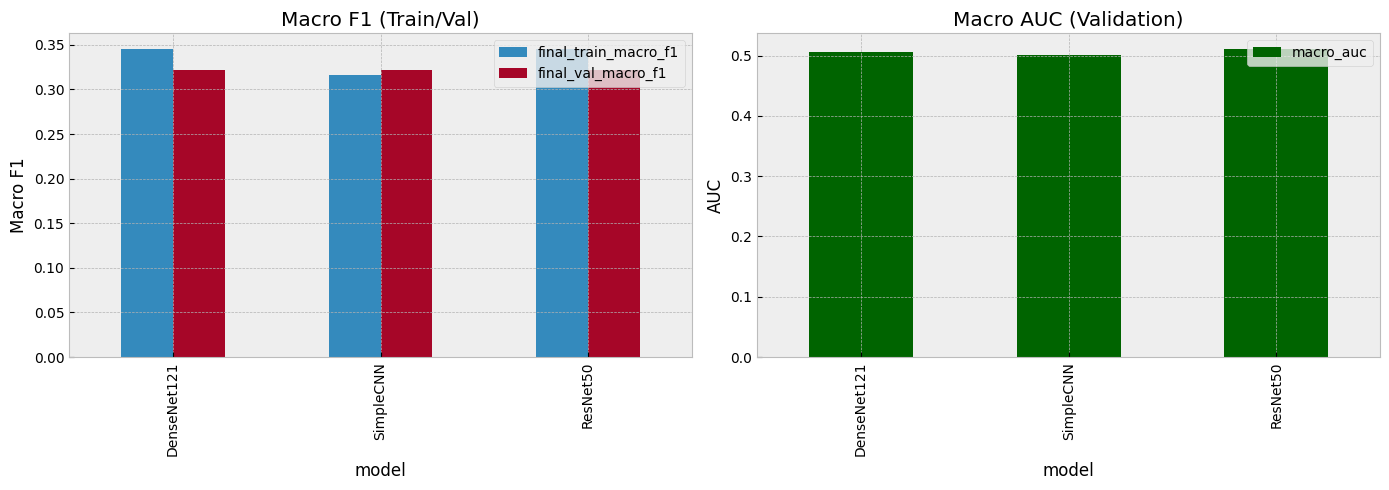

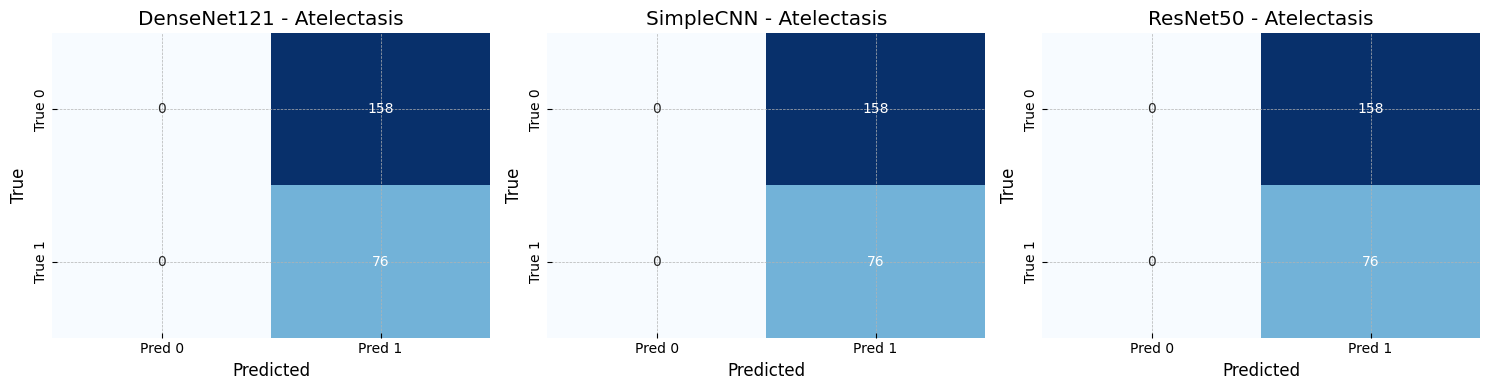

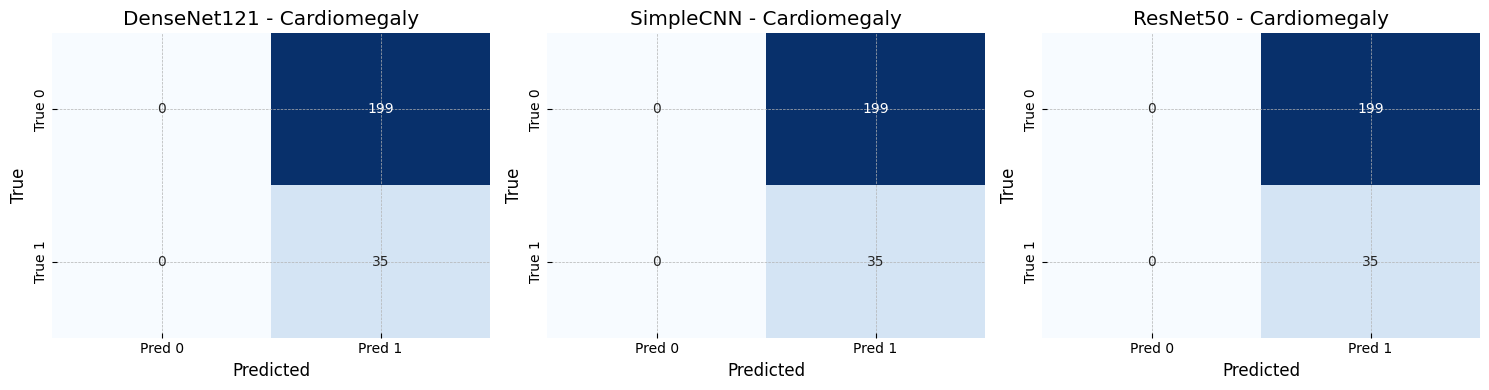

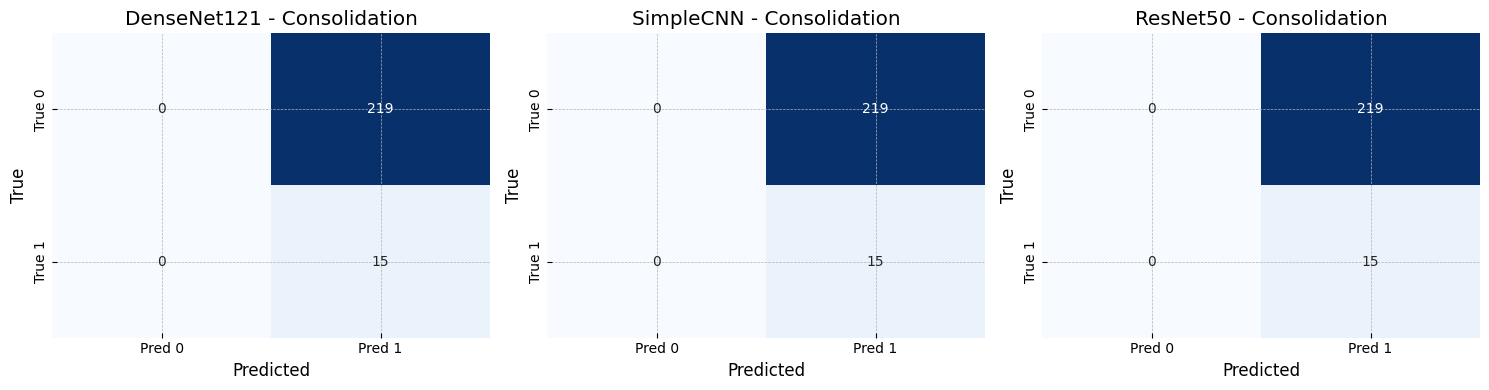

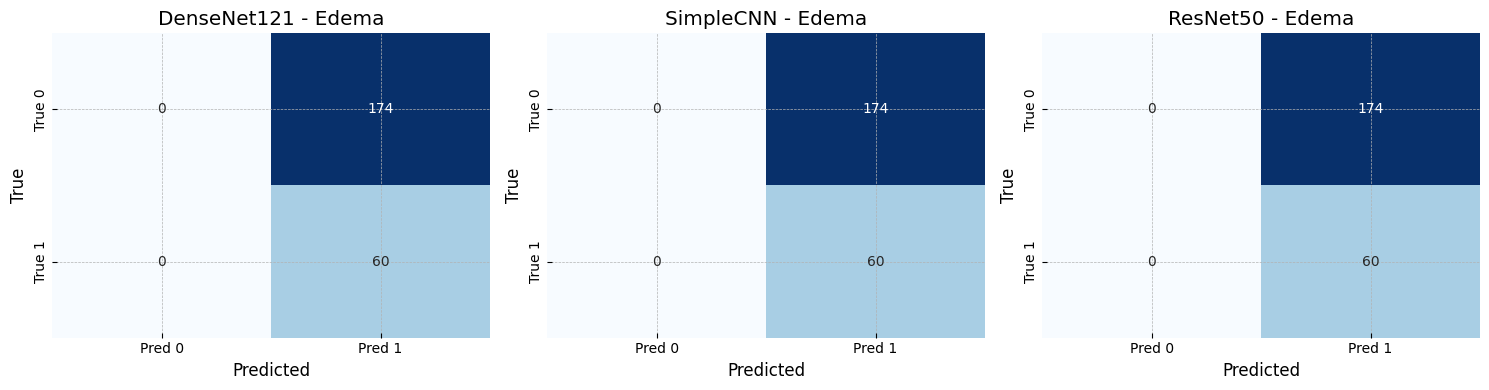

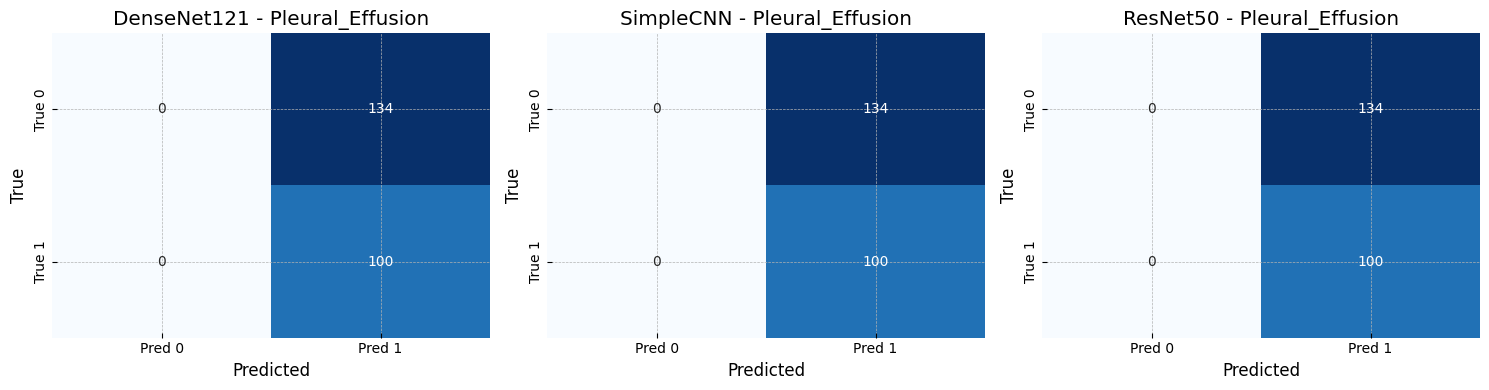


Model comparison (head):
             final_train_macro_f1  final_val_macro_f1  macro_auc  micro_auc  \
model                                                                         
DenseNet121              0.345431            0.321778   0.506292   0.668075   
SimpleCNN                0.316157            0.321778   0.500236   0.559589   
ResNet50                 0.345600            0.321778   0.511287   0.692668   

             sk_macro_f1  sk_micro_f1  auc_Atelectasis  auc_Cardiomegaly  \
model                                                                      
DenseNet121     0.375599     0.392857         0.455613          0.580761   
SimpleCNN       0.375599     0.392857         0.532187          0.524049   
ResNet50        0.375599     0.392857         0.531188          0.470711   

             auc_Consolidation  auc_Edema  auc_Pleural_Effusion  \
model                                                             
DenseNet121           0.487062   0.493918              0.514104

In [ ]:
try:
    print('\n=== Performing final model evaluations for comparison ===')
    densenet_info = evaluate_model_for_comparison(model, 'DenseNet121', H, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)
    cnn_info = evaluate_model_for_comparison(cnn_model, 'SimpleCNN', H_cnn, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)
    resnet_info = evaluate_model_for_comparison(resnet_model, 'ResNet50', H_resnet, valid_df, base_gen, IMG_SIZE, class_names, thresh=0.5)

    comparison_df = compare_models_and_report([densenet_info, cnn_info, resnet_info], class_names)
    print('\nModel comparison (head):')
    print(comparison_df.head())
except Exception as e:
    print('Error during model comparison:', e)